In [1]:
cd ..

/scratch/rd804/m-anode


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from src.nflow_utils import *
from src.generate_data_lhc import *
from src.utils import *
from src.flows import *

from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
import argparse
import pickle
import wandb
import sys


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from src.nflow_utils import *
from src.generate_data_lhc import *
from src.utils import *
from src.flows import *

from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
import argparse
import pickle
import wandb
import sys


In [ ]:


parser = argparse.ArgumentParser()
parser.add_argument('--n_sig',type=int , default=50000, help='signal train')
parser.add_argument('--mode_background', type=str, default='freeze', help='train, freeze, pretrained')


parser.add_argument('--epochs', type=int, default=2, help='epochs')
parser.add_argument('--batch_size', type=int, default = 256, help = 'batch size')
parser.add_argument('--mini_batch', type=int, default= 256, help='mini batch size')
parser.add_argument('--gpu', type=str, default='cuda:0', help='gpu to train on')
parser.add_argument('--data_loss_expr', type=str, default='true_likelihood', help='loss for SR region')


parser.add_argument('--resample', action='store_true', help='if data is to resampled')
parser.add_argument('--seed', type=int, default=11, help='seed')
parser.add_argument('--shuffle_split', action='store_true', help='if shuffle split is used')
parser.add_argument('--split', type=int, default=1, help='split number')
parser.add_argument('--data_dir', type=str, default='data/lhc_co', help='data directory')
parser.add_argument('--config_file', type=str, default='scripts/DE_MAF_model.yml', help='config file')
parser.add_argument('--S_config_file', type=str, default='scripts/DE_MAF_model.yml', help='config file')

parser.add_argument('--CR_path', type=str, default='results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0', help='CR data path')
parser.add_argument('--ensemble', action='store_true',default = True ,help='if ensemble is used')

parser.add_argument('--wandb', action='store_true', help='if wandb is used' )
parser.add_argument('--wandb_group', type=str, default='debugging_r_anode')
parser.add_argument('--wandb_job_type', type=str, default='lhc_co')
parser.add_argument('--wandb_run_name', type=str, default='try_10')
parser.add_argument('--include_samples', action='store_true', help='if samples are included')


args = parser.parse_args(args=[])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
np.random.seed(31)
np.random.seed(0)

number = 5
noise = np.random.multivariate_normal(np.zeros(number), np.eye(number), 10000)
print(noise)

np.random.seed(0)

number = 3
noise = np.random.multivariate_normal(np.zeros(number), np.eye(number), 10000)
print(noise)

[[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799]
 [-0.97727788  0.95008842 -0.15135721 -0.10321885  0.4105985 ]
 [ 0.14404357  1.45427351  0.76103773  0.12167502  0.44386323]
 ...
 [ 1.08454159  0.79774659 -1.619339   -0.33561619  0.51156504]
 [ 0.14332622  0.61851147  1.35543988  0.73207881  0.79574271]
 [ 1.40621491 -1.72057195 -0.25034177  0.58472799 -1.25082696]]
[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 ...
 [ 1.03930909  0.11820404 -0.76262253]
 [ 0.6060834  -0.40089775 -0.58545199]
 [-1.51127631  0.97684383  1.25550065]]


In [ ]:

if not os.path.exists(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}'):
    os.makedirs(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}')


if args.wandb:
    wandb.init(project="r_anode", config=args,
                group=args.wandb_group, job_type=args.wandb_job_type)

    wandb.run.name = args.wandb_run_name

# print wandb group


CUDA = True
device = torch.device(args.gpu if CUDA else "cpu")

SR_data, CR_data , true_w, sigma = resample_split(args.data_dir, n_sig = 1000, resample_seed = args.seed,resample = args.resample)

print('x_train shape', SR_data.shape)
print('true_w', true_w)
print('sigma', sigma)

if args.wandb:
    wandb.config.update({'true_w': true_w, 'sigma': sigma})




using first 1000 signal events for mock_data from 70000 events
sigma=2.216122847373821
true w: 0.006321443778454686
x_train shape (122124, 6)
true_w 0.006321443778454686
sigma 2.216122847373821


In [ ]:
params = preprocess_params_fit_all(SR_data)
SR_data_transform = preprocess_params_transform_all(SR_data, params)
label = SR_data_transform[:,-1]

In [36]:
params

{'min': array([ 3.30000183e+00, -2.15792006e-08,  1.59835815e-06,  0.00000000e+00,
         0.00000000e+00]),
 'max': array([3.69998655, 0.81603802, 1.03713078, 0.99019715, 0.97575351]),
 'mean': array([-0.29060835, -1.80754506, -2.11306146,  0.38134001, -0.05148202]),
 'std': array([1.80052416, 0.79245279, 1.40657804, 0.83634229, 0.93092444])}

In [20]:
logit_SR, mask = logit_transform(SR_data[:,:-1], params['min'], params['max'])
logit_SR_masked = logit_SR[mask]

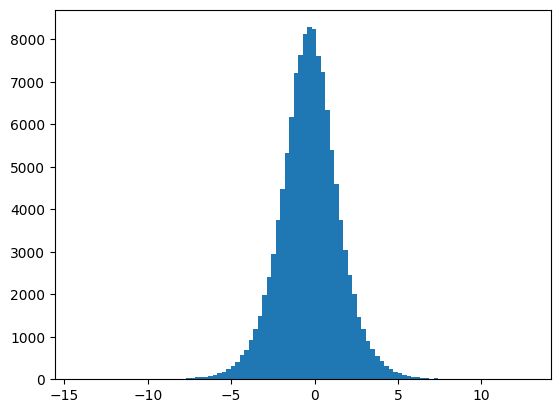

In [22]:
plt.hist(logit_SR_masked[:,0], bins = 100)
plt.show()

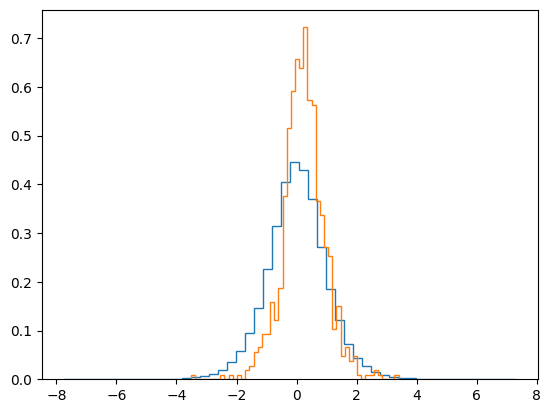

In [51]:
plt.hist(SR_data_transform[:,0][label==0], bins = 50, density=True,histtype='step')
plt.hist(SR_data_transform[:,0][label==1], bins = 50, density=True, histtype='step')
#plt.hist(, bins = 50, density=True)
plt.show()

In [38]:
param_tensor = {}
for keys in params.keys():
    param_tensor[keys] = torch.tensor(params[keys],dtype=torch.float32)

SR_data_tensor = torch.tensor(SR_data_transform, dtype=torch.float32)
       

In [40]:
SR_inversed = inverse_transform_all(SR_data_tensor, param_tensor)

In [44]:
old_label = SR_data[:,-1]

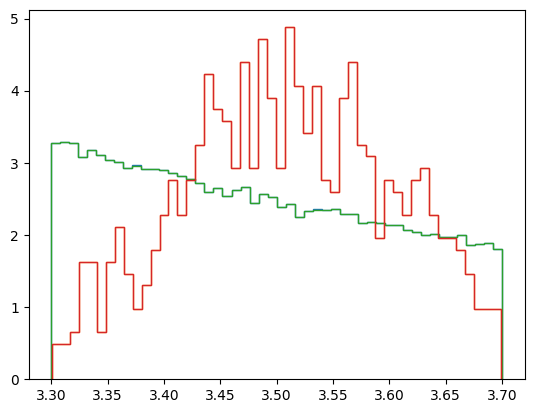

In [45]:
plt.hist(SR_inversed[:,0][label==0], bins = 50, density=True,histtype='step')
plt.hist(SR_inversed[:,0][label==1], bins = 50, density=True, histtype='step')
plt.hist(SR_data[:,0][old_label==0], bins = 50, density=True, histtype='step')
plt.hist(SR_data[:,0][old_label==1], bins = 50, density=True, histtype='step')
plt.show()

# Mass fit

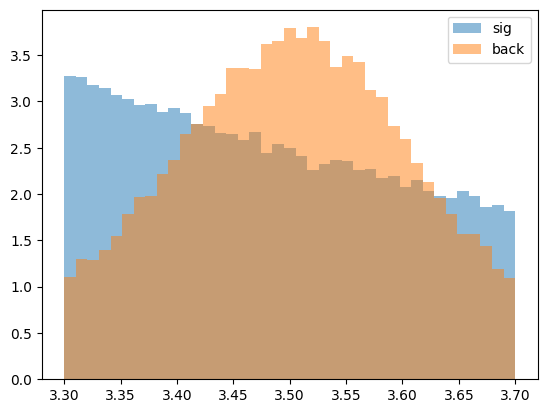

In [6]:
#data = np.concatenate([SR_data, CR_data[CR_data[:,-0]>3]], axis=0)
bins = np.linspace(3.3, 3.7, 40)
labels = SR_data[:,-1]
mass = SR_data[:,0]

#mass_cut = (mass<3.7) & (mass>3.3)

#mass = mass[mass_cut]
#labels = labels[mass_cut]

plt.hist(mass[labels==0], bins=bins, alpha=0.5, label='sig', density=True)
plt.hist(mass[labels==1], bins=bins, alpha=0.5, label='back', density=True)
plt.legend()
plt.show()



In [10]:
# histogram density of data
bins_ = np.linspace(3.3, 3.7, 40)
bins_back, hist_back = np.histogram(mass[labels==0], bins=bins_, density=True,
                                    )
bins_sig, hist_sig = np.histogram(mass[labels==1], bins=bins_, density=True)
print('hist_sig', hist_sig)
print('hist_back', hist_back)
print('bins_back', bins_back)

hist_sig [3.3        3.31025641 3.32051282 3.33076923 3.34102564 3.35128205
 3.36153846 3.37179487 3.38205128 3.39230769 3.4025641  3.41282051
 3.42307692 3.43333333 3.44358974 3.45384615 3.46410256 3.47435897
 3.48461538 3.49487179 3.50512821 3.51538462 3.52564103 3.53589744
 3.54615385 3.55641026 3.56666667 3.57692308 3.58717949 3.5974359
 3.60769231 3.61794872 3.62820513 3.63846154 3.64871795 3.65897436
 3.66923077 3.67948718 3.68974359 3.7       ]
hist_back [3.3        3.31025641 3.32051282 3.33076923 3.34102564 3.35128205
 3.36153846 3.37179487 3.38205128 3.39230769 3.4025641  3.41282051
 3.42307692 3.43333333 3.44358974 3.45384615 3.46410256 3.47435897
 3.48461538 3.49487179 3.50512821 3.51538462 3.52564103 3.53589744
 3.54615385 3.55641026 3.56666667 3.57692308 3.58717949 3.5974359
 3.60769231 3.61794872 3.62820513 3.63846154 3.64871795 3.65897436
 3.66923077 3.67948718 3.68974359 3.7       ]
bins_back [3.27485332 3.26601539 3.17602924 3.14228443 3.07399136 3.0225707
 2.95829488

In [8]:
from scipy.stats import rv_histogram
bins = np.linspace(3.3, 3.7, 50)

hist_sig = np.histogram(mass[labels==1], bins=bins, density=True)
density_sig = rv_histogram(hist_sig)

hist_back = np.histogram(mass[labels==0], bins=bins, density=True)
density_back = rv_histogram(hist_back)



In [20]:
_x_test = np.load(f'{args.data_dir}/x_test.npy')
m_test = _x_test[:,0]
labels_test = _x_test[:,-1]

In [28]:
len(labels_test)

366192

In [11]:
def R(m):
    return density_sig.pdf(m)/density_back.pdf(m)

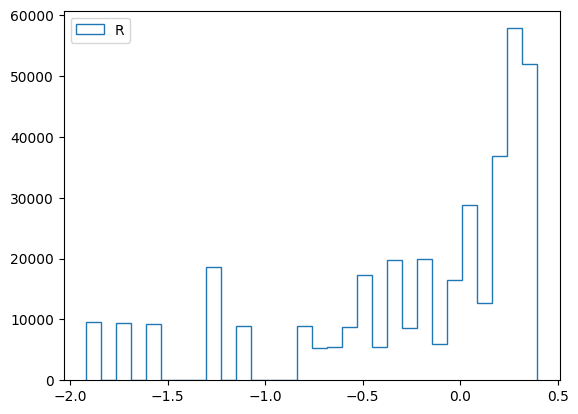

In [33]:
plt.hist((R(m_test)-1)/R(m_test), bins=30, label='R', histtype='step')
#plt.hist(R(m_test[labels_test==1]), bins=30, label='R_sig', histtype='step')
#plt.hist(R(m_test[labels_test==0]), bins=30, label='R_back', histtype='step')
plt.legend()
#plt.yscale('log')
plt.show()

In [46]:
np.save('./data/lhc_co/true_mass.npy', mass)
np.save('./data/lhc_co/true_labels.npy', labels)

In [15]:
bins_back

array([3.27485332, 3.26601539, 3.17602924, 3.14228443, 3.07399136,
       3.0225707 , 2.95829488, 2.97597073, 2.89000181, 2.92776386,
       2.86911217, 2.75341568, 2.73573983, 2.66262608, 2.65218126,
       2.57906751, 2.66985711, 2.44730206, 2.53969856, 2.49390204,
       2.41114691, 2.26411596, 2.32517799, 2.37177797, 2.35088832,
       2.26009872, 2.27215044, 2.17654015, 2.19019876, 2.07610917,
       2.15163327, 2.03593678, 1.97728509, 1.95157476, 2.03513333,
       1.97889198, 1.85998171, 1.8816748 , 1.81900587])

In [20]:
from scipy.interpolate import interp1d

In [25]:
density_back_dig

array([ 1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
        9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
       12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14,
       14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16,
       16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18,
       18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20,
       20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 23,
       23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25,
       25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
       27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29,
       29, 29, 30, 30, 30

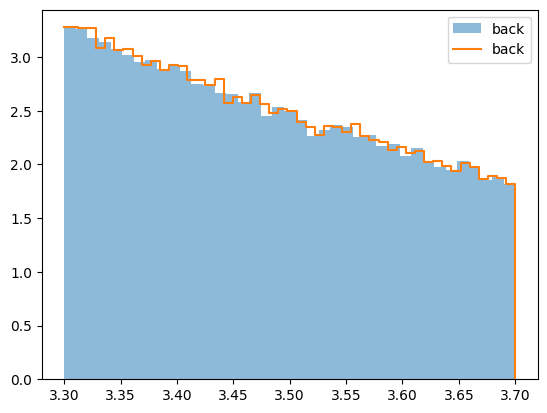

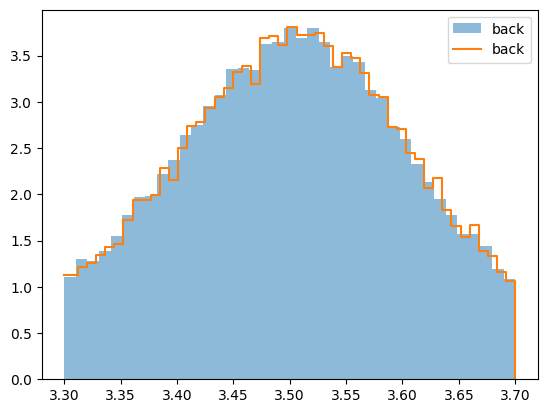

In [45]:
mass_array = np.linspace(3.3, 3.7, 100)
prob_back = density_back.pdf(mass_array)
prob_sig = density_sig.pdf(mass_array)

plt.hist(mass[labels==0], bins=bins_, alpha=0.5, label='back', density=True)
plt.step(mass_array, prob_back, where='post', label='back')
plt.legend()
plt.show()

plt.hist(mass[labels==1], bins=bins_, alpha=0.5, label='back', density=True)
plt.step(mass_array, prob_sig, where='post', label='back')
plt.legend()
plt.show()

In [51]:
mass_array = np.linspace(3.3, 3.7, 100)
mass_array = torch.tensor(mass_array)
prob_back = density_back.pdf(mass_array)
prob_sig = density_sig.pdf(mass_array)

In [151]:
len(mass_array), len(density_back_dig)

(40, 40)

: 

In [146]:
len(bins_back), len(density_back_dig)

(39, 40)

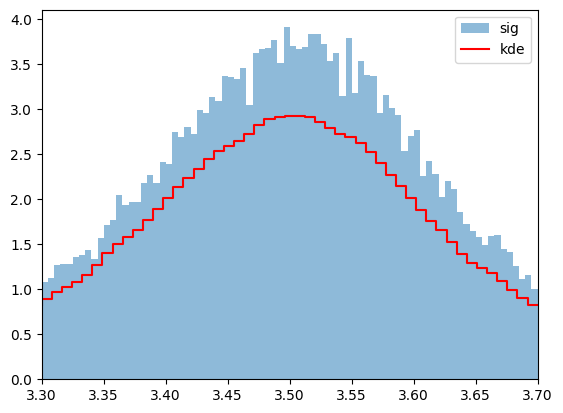

In [22]:
from sklearn.neighbors import KernelDensity

kde_sig = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(mass[labels==1].reshape(-1,1))


m = np.linspace(3.3, 3.7, 50)

log_dens = np.exp(kde_sig.score_samples(m.reshape(-1,1)))
plt.hist( mass[mass_cut][labels[mass_cut]==1] , bins=80, alpha=0.5, label='sig', density=True)
plt.step(m, log_dens, color='r', label='kde')
plt.xlim(3.3, 3.7)
plt.legend()
plt.show()


with open('./data/lhc_co/mass_kde_sig.pkl', 'wb') as f:
    pickle.dump(kde_sig, f)


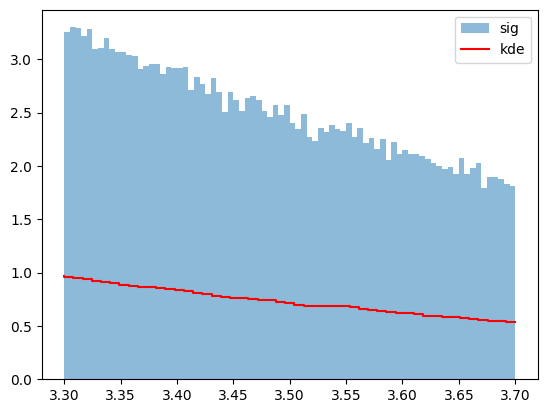

In [25]:
from sklearn.neighbors import KernelDensity

kde_back = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(mass[labels==0].reshape(-1,1))

m = np.linspace(3.3, 3.7, 50)
log_dens = np.exp(kde_back.score_samples(m.reshape(-1,1)))
plt.hist(mass[mass_cut][labels[mass_cut]==0], bins=80, alpha=0.5, label='sig', density=True)
plt.step(m, log_dens, color='r', label='kde')
plt.legend()
plt.show()

with open('./data/lhc_co/mass_kde_back.pkl', 'wb') as f:
    pickle.dump(kde_back, f)


# R-ANODE

In [6]:
pre_parameters_SR = preprocess_params_fit(SR_data)
# save pre_parameters of SR
with open(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/pre_parameters.pkl','wb') as f:
    pickle.dump(pre_parameters_SR, f)


# load pre_parameters of CR 
with open(f'{args.CR_path}/pre_parameters.pkl', 'rb') as f:
    pre_parameters_CR = pickle.load(f)

pre_parameters_SR = pre_parameters_CR


NameError: name 'SR_data' is not defined

In [56]:

_, mask_CR = logit_transform(SR_data[:,1:-1], pre_parameters_CR['min'],
                             pre_parameters_CR['max'])
_, mask_SR = logit_transform(SR_data[:,1:-1], pre_parameters_SR['min'],
                                pre_parameters_SR['max'])

mask = mask_CR & mask_SR

x_train = SR_data[mask]

# have two seperate transforms of the data for model_S and model_B
x_train_S = preprocess_params_transform(x_train, pre_parameters_CR) 
#x_train_B = preprocess_params_transform(x_train, pre_parameters_CR)
x_train_B = preprocess_params_transform(x_train, pre_parameters_CR)


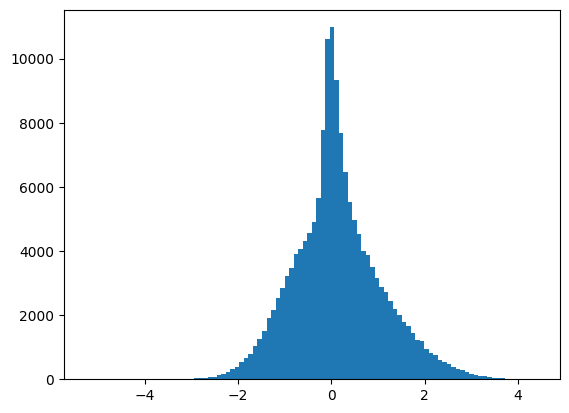

In [57]:
plt.hist(x_train_S[:,1], bins=100)
plt.show()

In [58]:


# create masked test data
_x_test = np.load(f'{args.data_dir}/x_test.npy')
_, mask_CR = logit_transform(_x_test[:,1:-1], pre_parameters_CR['min'],
                                pre_parameters_CR['max'])
_, mask_SR = logit_transform(_x_test[:,1:-1], pre_parameters_SR['min'],
                                pre_parameters_SR['max'])
mask_test = mask_CR & mask_SR
x_test = _x_test[mask_test]

x_test_CR = preprocess_params_transform(x_test, pre_parameters_CR)
#x_test_SR = preprocess_params_transform(x_test, pre_parameters_SR)
x_test_SR = preprocess_params_transform(x_test, pre_parameters_CR)



In [59]:

if not args.shuffle_split:    
    data_train_S, data_val_S = train_test_split(x_train_S, test_size=0.2, random_state=args.seed)
    data_train_B, data_val_B = train_test_split(x_train_B, test_size=0.2, random_state=args.seed)

else:
    ss_data = ShuffleSplit(n_splits=20, test_size=0.5, random_state=22)

    print(f'doing a shuffle split with split number {args.split}')

    for i, (train_index, test_index) in enumerate(ss_data.split(x_train)):
        if i == args.split:
            data_train_S, data_val_S = x_train_S[train_index], x_train_S[test_index]
            data_train_B, data_val_B = x_train_B[train_index], x_train_B[test_index]
            break

#data_train_B = x_train_B
#data_val_B = x_train_B

#data_train_S = x_train_S
#data_val_S = x_train_S

#x_test = preprocess_params_transform(_x_test, pre_parameters)


traintensor_S = torch.from_numpy(data_train_S.astype('float32'))
traintensor_B = torch.from_numpy(data_train_B.astype('float32'))

valtensor_S = torch.from_numpy(data_val_S.astype('float32'))
valtensor_B = torch.from_numpy(data_val_B.astype('float32'))
#testtensor = torch.from_numpy(x_test.astype('float32')).to(device)

testtensor_S = torch.from_numpy(x_test_SR.astype('float32'))
testtensor_B = torch.from_numpy(x_test_CR.astype('float32'))

print('X_train shape', traintensor_S.shape)
print('X_train shape', traintensor_B.shape)

print('X_val shape', valtensor_S.shape)
print('X_val shape', valtensor_B.shape)

print('X_test shape', testtensor_S.shape)
print('X_test shape', testtensor_B.shape)

pre_parameters_S_tensor = pre_parameters_SR.copy()
pre_parameters_B_tensor = pre_parameters_CR.copy()

for key in pre_parameters_S_tensor.keys():
    pre_parameters_S_tensor[key] = torch.from_numpy(pre_parameters_S_tensor[key].astype('float32'))

for key in pre_parameters_B_tensor.keys():
    pre_parameters_B_tensor[key] = torch.from_numpy(pre_parameters_B_tensor[key].astype('float32'))





X_train shape torch.Size([127164, 6])
X_train shape torch.Size([127164, 6])
X_val shape torch.Size([31792, 6])
X_val shape torch.Size([31792, 6])
X_test shape torch.Size([366150, 6])
X_test shape torch.Size([366150, 6])


In [10]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal, StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import *
from nflows.transforms.permutations import ReversePermutation, RandomPermutation
# import bactchnorm
from nflows.transforms.normalization import BatchNorm
from nflows.nn.nets import ResidualNet
from nflows.transforms.made import MADE

In [11]:


# num_layers = 8
# base_dist = StandardNormal(shape=[4])

#transforms = []
#for _ in range(num_layers):
 #   transforms.append(MaskedAffineAutoregressiveTransform(features=4, hidden_features=64, use_residual_blocks=False,
   #                                                       context_features=1, random_mask=True,
    #                                                      num_blocks=2, use_batch_norm=True,
     #                                                     activation=F.leaky_relu, dropout_probability=0.2))
  #  transforms.append(BatchNorm(features=4))
  #  transforms.append(RandomPermutation(features=4))

#transform = CompositeTransform(transforms)

#model_S = Flow(transform, base_dist).to(device)

In [12]:
flow_params_rec_energy = {'num_blocks': 2, #num of layers per block
                              'features': 4,
                              'context_features': 1,
                              'hidden_features': 64,
                              'use_residual_blocks': False,
                              'use_batch_norm': True,
                              'dropout_probability': 0.0,
                              'activation':getattr(F, 'leaky_relu'),
                              'random_mask': True,
                              'num_bins': 8,
                              'tails':'linear',
                              'tail_bound': 9,
                              'min_bin_width': 1e-6,
                              'min_bin_height': 1e-6,
                              'min_derivative': 1e-6}
rec_flow_blocks = []
for _ in range(6):
    rec_flow_blocks.append(
        MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
            **flow_params_rec_energy))
    rec_flow_blocks.append(RandomPermutation(4))
rec_flow_transform = CompositeTransform(rec_flow_blocks)
# _sample not implemented:
#rec_flow_base_distribution = distributions.DiagonalNormal(shape=[args.num_layer+1])
rec_flow_base_distribution = StandardNormal(shape=[4])

model_S = flows.Flow(transform=rec_flow_transform, distribution=rec_flow_base_distribution).to(device)

In [13]:

if args.mode_background == 'train':
    pass

elif args.mode_background == 'freeze':
 #   val_losses = np.load(f'{args.CR_path}/my_ANODE_model_val_losses.npy')
    val_losses = np.load(f'{args.CR_path}/valloss_list.npy')
    best_epochs = np.argsort(val_losses)[0:10]
    #model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{best_epoch}.par", device=device)
   # model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/model_CR_{best_epoch}.pt", device=device)

elif args.mode_background == 'pretrained':
    val_losses = np.load(f'{args.CR_path}/my_ANODE_model_val_losses.npy')
    best_epoch = np.argmin(val_losses)
    model_B = DensityEstimator(args.config_file, eval_mode=False, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{best_epoch}.par", device=device)




valloss = []
trainloss = []



pre_parameters = {}

pre_parameters['CR'] = pre_parameters_B_tensor
pre_parameters['SR'] = pre_parameters_S_tensor


In [14]:
#samples_train = []

#for i,epochs in enumerate(best_epochs):

 #   cond_inputs = traintensor_B[i*10000: (i+1)*10000,0].reshape(-1,1)
 #   model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/model_CR_{epochs}.pt", device=device)
 #   samples_train.append(model_B.model.sample(num_samples=len(cond_inputs), 
  #                                            cond_inputs= cond_inputs).detach().cpu().numpy())


In [15]:
#samples_train = np.array(samples_train)
#samples_train = np.concatenate(samples_train, axis=0)
#samples_train = np.hstack((traintensor_B[:,0].detach().cpu().numpy().reshape(-1,1) , 
             #              samples_train, traintensor_B[:,-1].detach().cpu().numpy().reshape(-1,1)))

In [16]:
# samples_val = []

#for i,epochs in enumerate(best_epochs):
 #   model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/model_CR_{epochs}.pt", device=device)
  #  cond_inputs = valtensor_B[i*10000: (i+1)*10000,0].reshape(-1,1)
   # samples_val.append(model_B.model.sample(num_samples=len(cond_inputs),cond_inputs= cond_inputs).detach().cpu().numpy())


In [17]:
#samples_val = np.array(samples_val)
#samples_val = np.concatenate(samples_val, axis=0)
#samples_val = np.hstack((valtensor_B[:,0].detach().cpu().numpy().reshape(-1,1) , 
 #                          samples_val, valtensor_B[:,-1].detach().cpu().numpy().reshape(-1,1)))

In [18]:
samples_train = np.load('data/lhc_co/samples_train.npy')[0:20_000,:]
samples_val = np.load('data/lhc_co/samples_val.npy')[0:20_000,:]

In [19]:
samples_train = torch.from_numpy(samples_train.astype('float32')).to(device)
samples_val = torch.from_numpy(samples_val.astype('float32')).to(device)

In [20]:
train_data = torch.vstack((traintensor_S.to(device), samples_train))
trainlabels = torch.hstack((torch.ones(len(traintensor_S)), torch.zeros(len(samples_train)))).to(device)
train_data[:,-1] = trainlabels

val_data = torch.vstack((valtensor_S.to(device), samples_val))
vallabels = torch.hstack((torch.ones(len(valtensor_S)), torch.zeros(len(samples_val)))).to(device)
val_data[:,-1] = vallabels


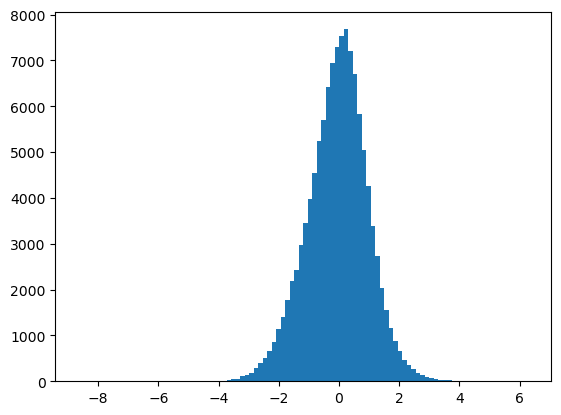

In [21]:
plt.hist(train_data[:,3].detach().cpu().numpy(), bins=100)
plt.show()

In [22]:
log_B_val = []
for i in best_epochs:
    model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/model_CR_{i}.pt", device=device)
    log_B_ = model_B.model.log_probs(inputs=val_data[:,1:-1], cond_inputs=val_data[:,0].reshape(-1,1))
    log_B_val.append(log_B_.detach().cpu().numpy())

log_B_val = np.array(log_B_val)
log_B_val = np.mean(log_B_val, axis=0)

DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_60.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_79.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_45.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_44.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_48.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_95.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_53.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows

In [23]:
log_B_train = []
for i in best_epochs:
    model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/model_CR_{i}.pt", device=device)
    log_B_ = model_B.model.log_probs(inputs=train_data[:,1:-1], cond_inputs=train_data[:,0].reshape(-1,1))
    log_B_train.append(log_B_.detach().cpu().numpy())


log_B_train = np.array(log_B_train)
log_B_train = np.mean(log_B_train, axis=0)

DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_60.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_79.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_45.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_44.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_48.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_95.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_53.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows

In [24]:
log_B_train_tensor = torch.from_numpy(log_B_train.astype('float32')).to(device)
log_B_val_tensor = torch.from_numpy(log_B_val.astype('float32')).to(device)

In [25]:
train_tensor = torch.utils.data.TensorDataset(train_data, log_B_train_tensor)
val_tensor = torch.utils.data.TensorDataset(val_data, log_B_val_tensor)
 
#test_tensor = torch.utils.data.TensorDataset(testtensor)


# Use the standard pytorch DataLoader
batch_size = args.batch_size
trainloader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

test_batch_size=batch_size*5
valloader = torch.utils.data.DataLoader(val_tensor, batch_size=test_batch_size, shuffle=False)

In [26]:
torch.amin(train_data[:,1:-1])

tensor(-8.6742, device='cuda:0')

In [27]:
#train_data = inverse_transform(traintensor_S, pre_parameters['SR']).cpu().detach().numpy()
#val_data = inverse_transform(valtensor_S, pre_parameters['SR']).cpu().detach().numpy()

train_data = inverse_transform(traintensor_S, pre_parameters['CR']).cpu().detach().numpy()
val_data = inverse_transform(valtensor_S, pre_parameters['CR']).cpu().detach().numpy()


all_data = np.vstack((train_data, val_data))




In [28]:
traintensor_S = traintensor_S.to(device)
traintensor_B = traintensor_B.to(device)
valtensor_S = valtensor_S.to(device)
valtensor_B = valtensor_B.to(device)

In [29]:
sum(p.numel() for p in model_S.parameters()
                               if p.requires_grad)

90024

In [30]:
# one cycle lr scheduler
epochs = 100
#optimizer = torch.optim.AdamW(model_S.model.parameters())
optimizer = torch.optim.AdamW(model_S.parameters(), weight_decay=1e-2, lr=3e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(trainloader), epochs=epochs, anneal_strategy='linear')
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-3,cycle_momentum=False, step_size_up = len(trainloader)*10)

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  0 trainloss:  4.504332491515249 valloss:  2.9517291613987515


/tmp/ipykernel_2366602/2336281730.py:64: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/aten/src/ATen/native/IndexingUtils.h:27.)
  x_samples = x_samples[~np.isnan(x_samples).any(axis=1)]


x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


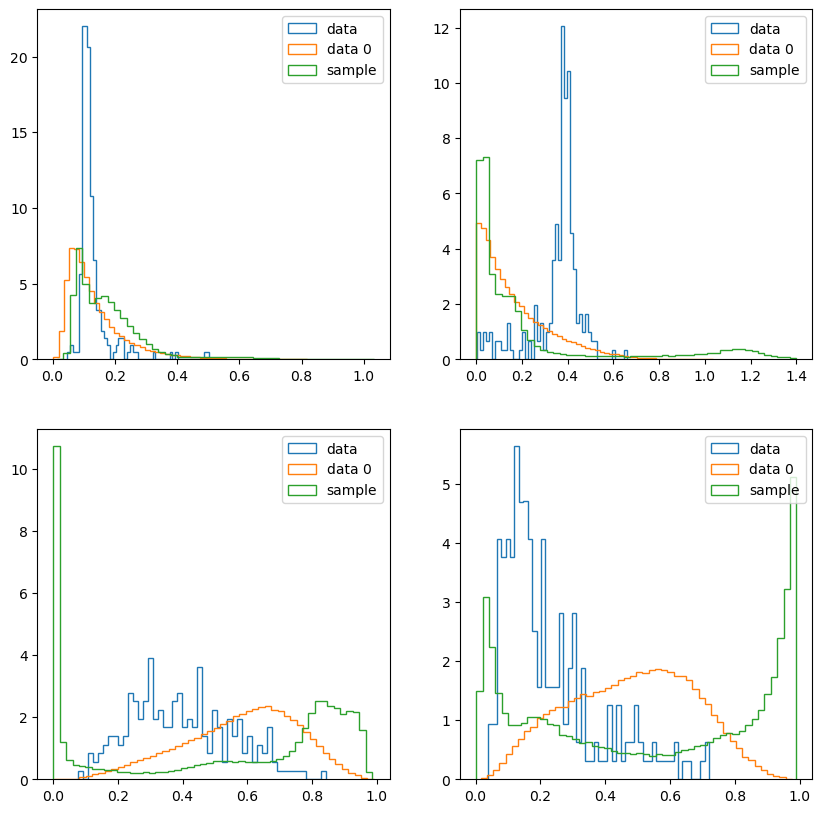

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  1 trainloss:  4.5062598361428785 valloss:  2.951915168762207
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


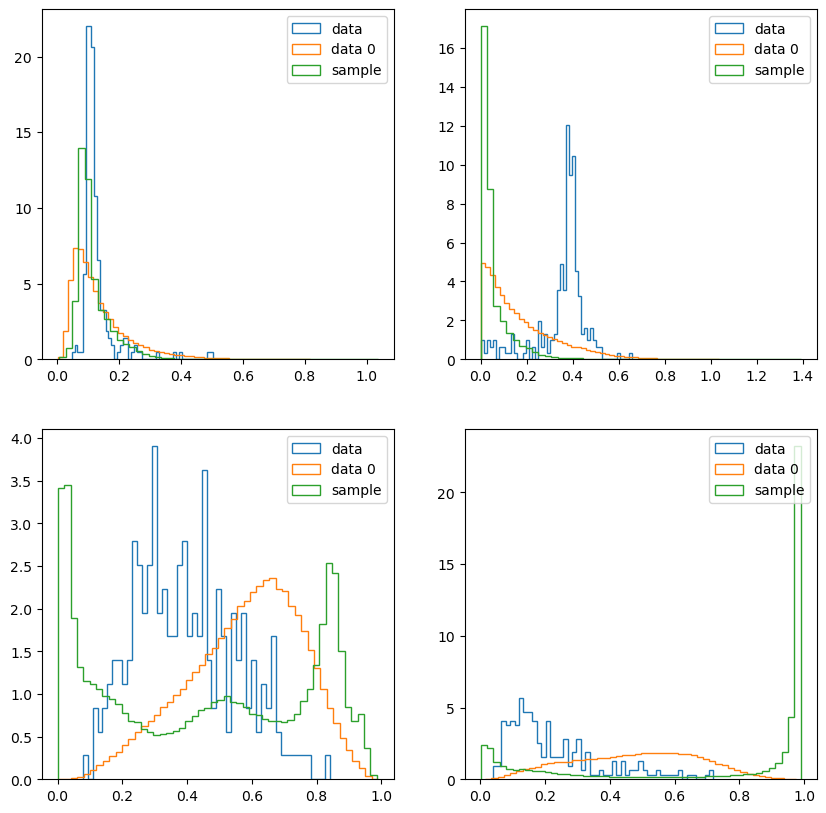

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  2 trainloss:  4.50554650333712 valloss:  2.9512422152927944
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


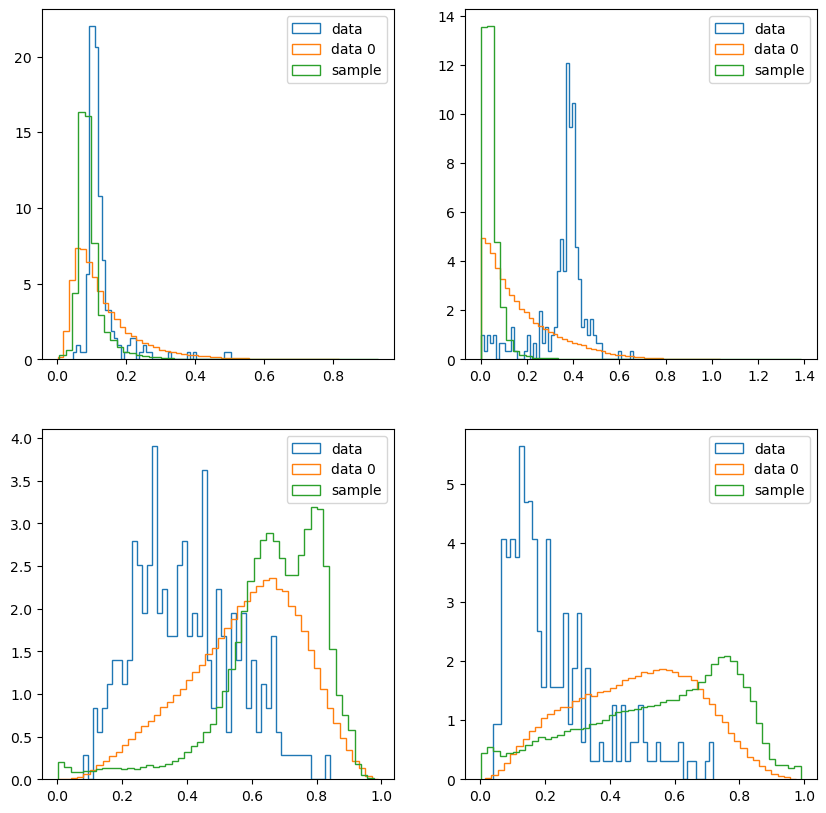

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  3 trainloss:  4.502486293352248 valloss:  2.951511151450021
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


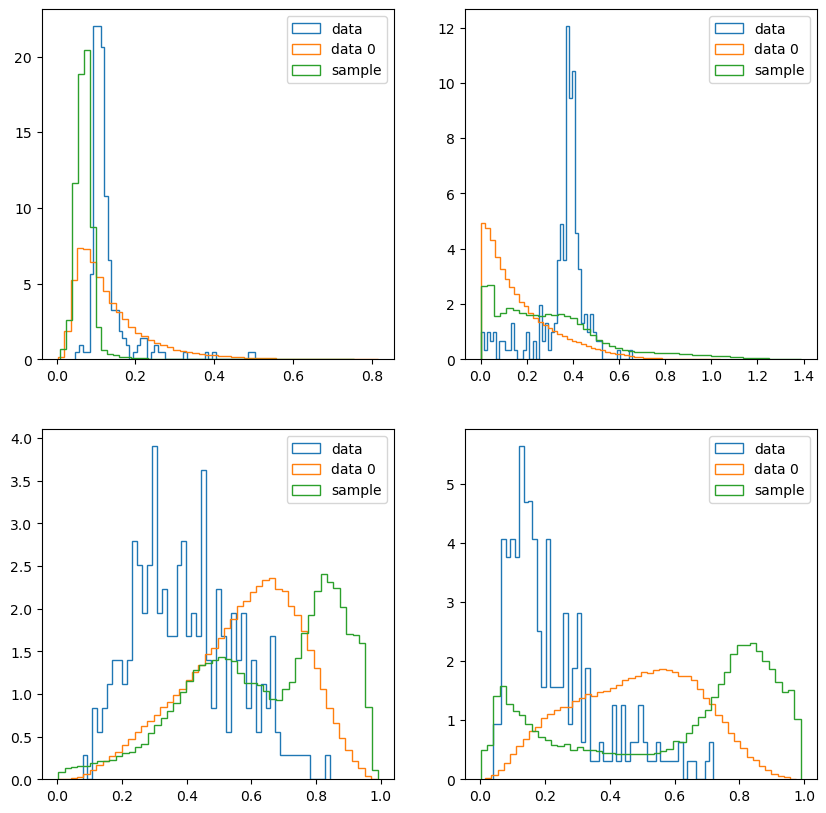

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  4 trainloss:  4.505598046421226 valloss:  2.9511466435023714
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


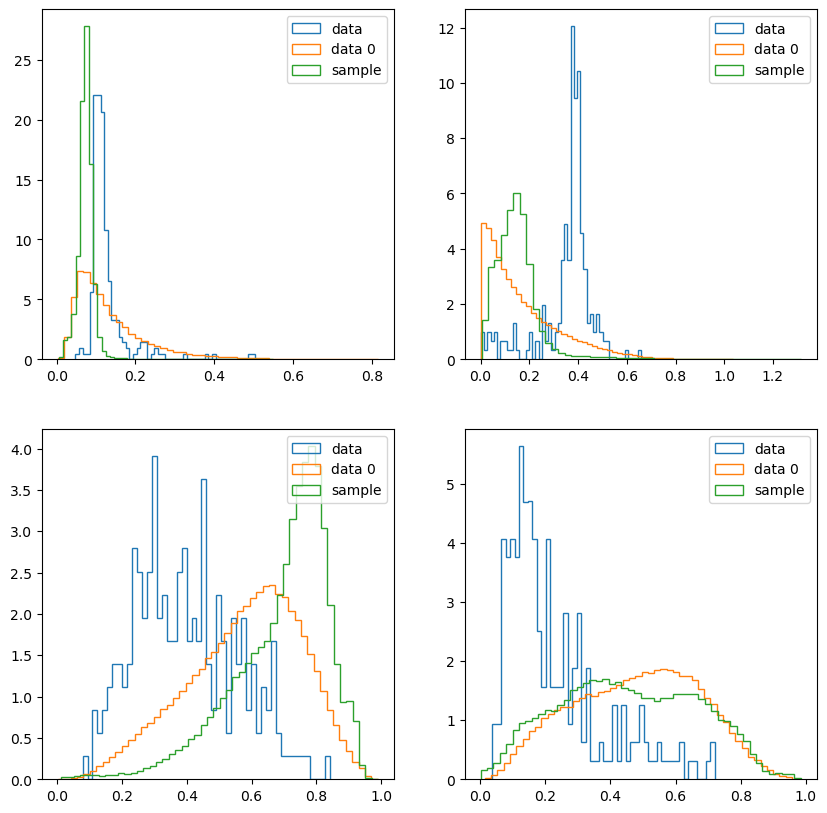

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  5 trainloss:  4.50213267237013 valloss:  2.951089872632708
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


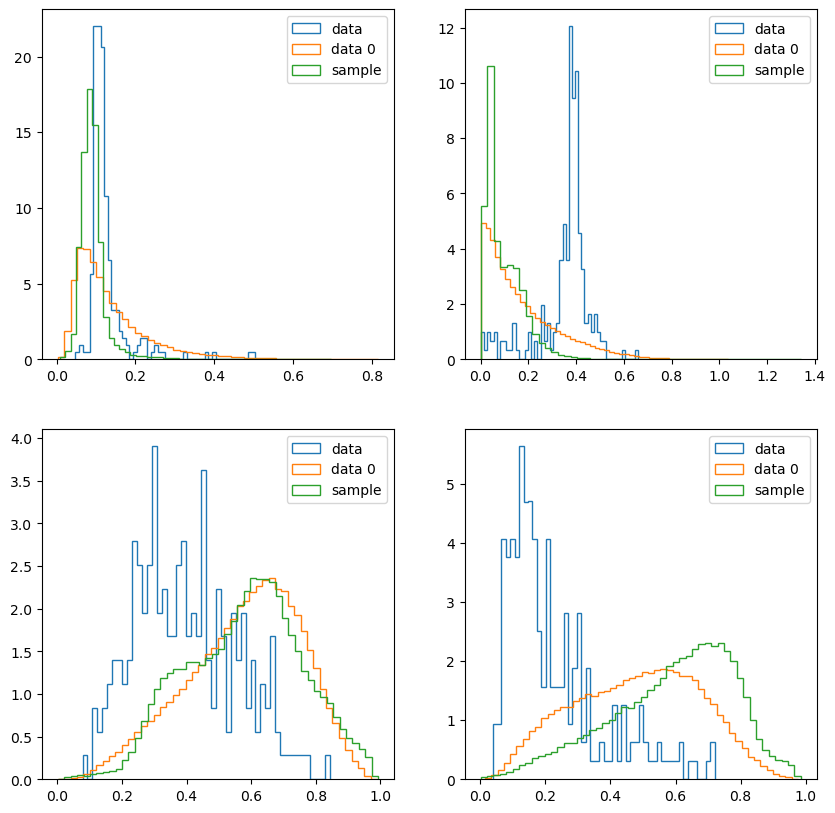

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  6 trainloss:  4.5054775884208595 valloss:  2.9513374737330844
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


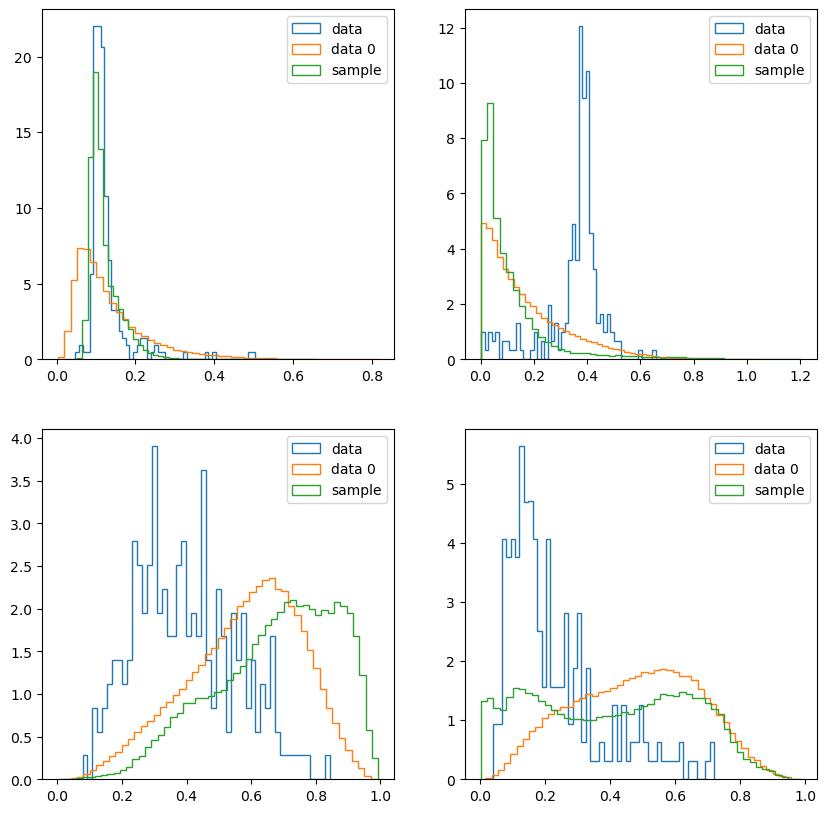

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  7 trainloss:  4.504675943607339 valloss:  2.9513828550066266
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


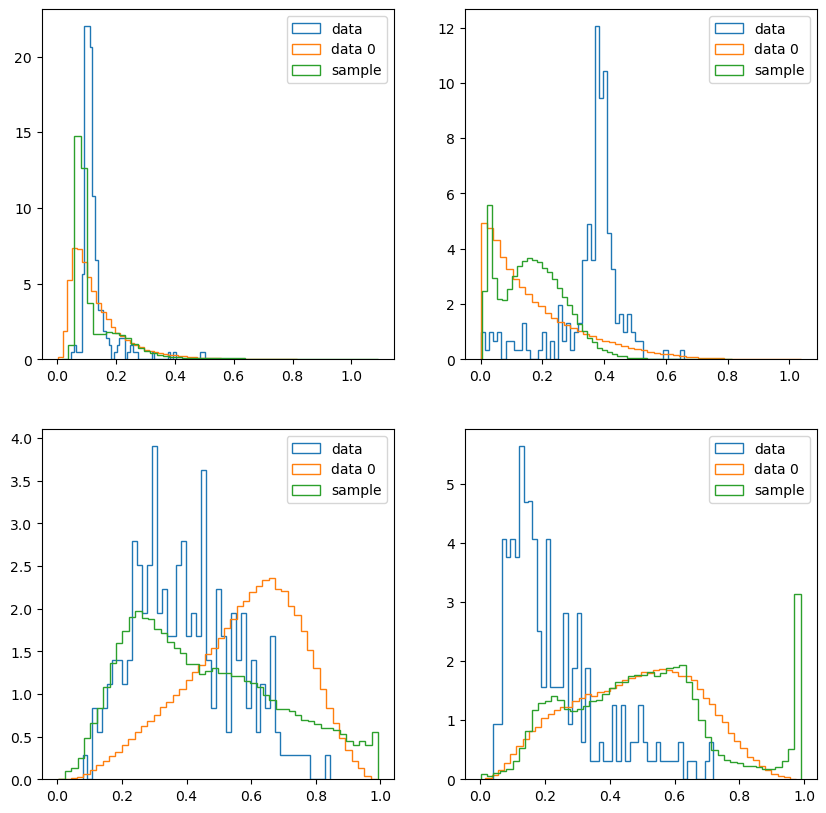

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  8 trainloss:  4.505342410800244 valloss:  2.9515786579677035
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


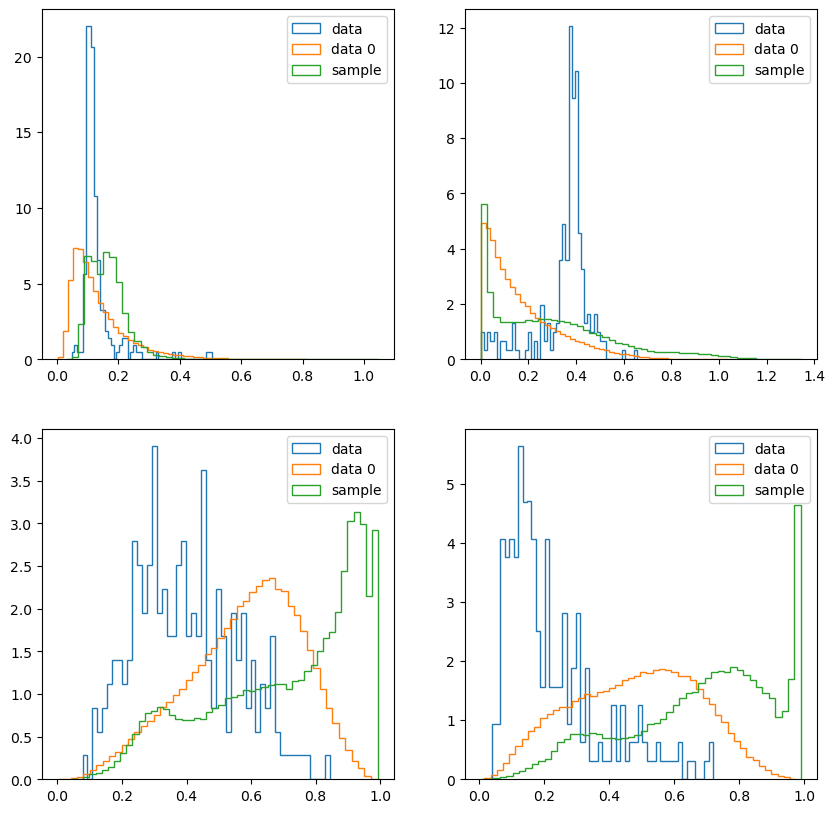

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  9 trainloss:  4.500264889274547 valloss:  2.9511805125645227
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


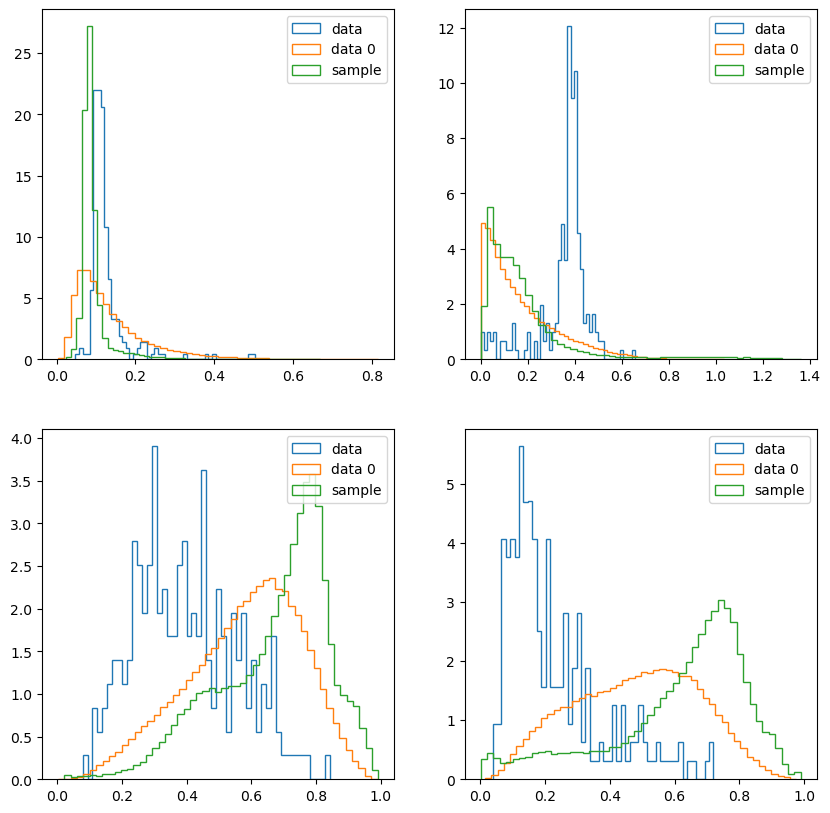

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  10 trainloss:  4.504193691386637 valloss:  2.9512008258274625
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


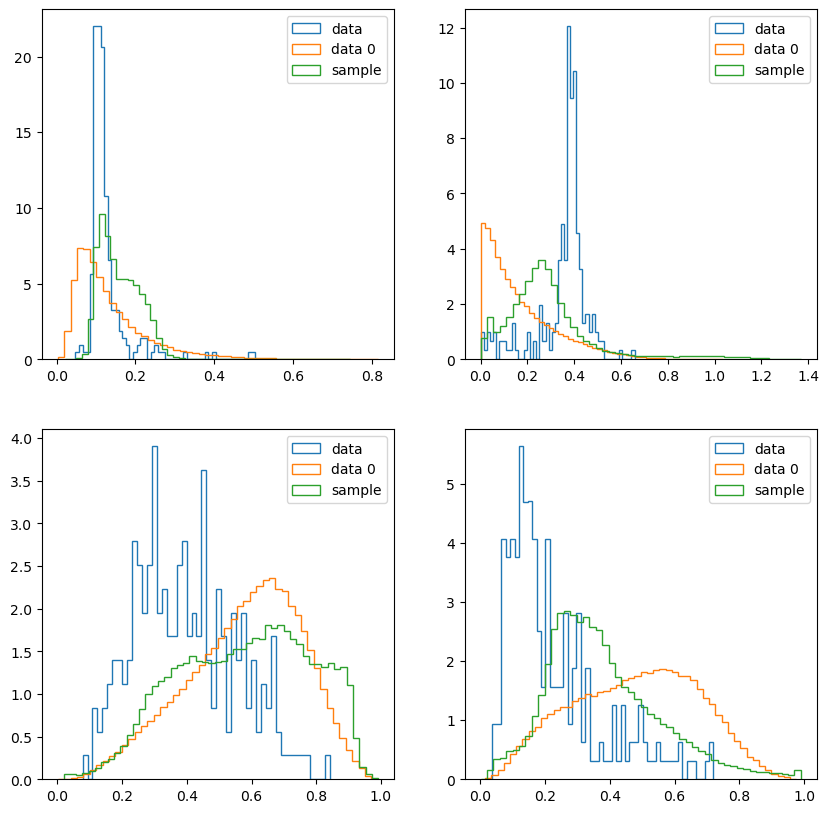

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  11 trainloss:  4.502895864266455 valloss:  2.951213714054653
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


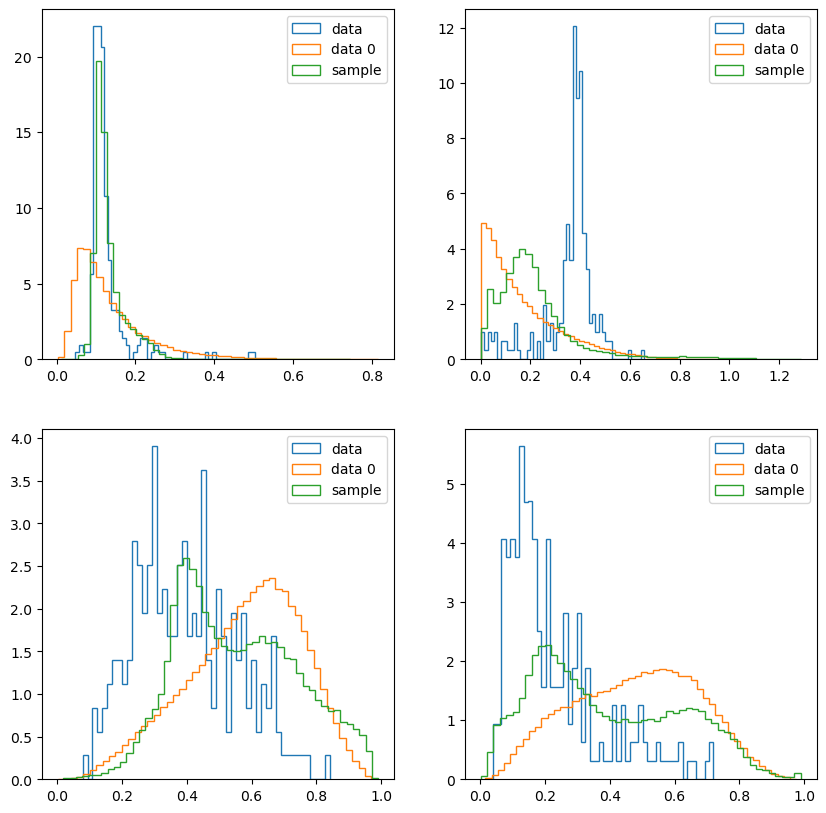

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  12 trainloss:  4.504676327466445 valloss:  2.9511614390781946
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


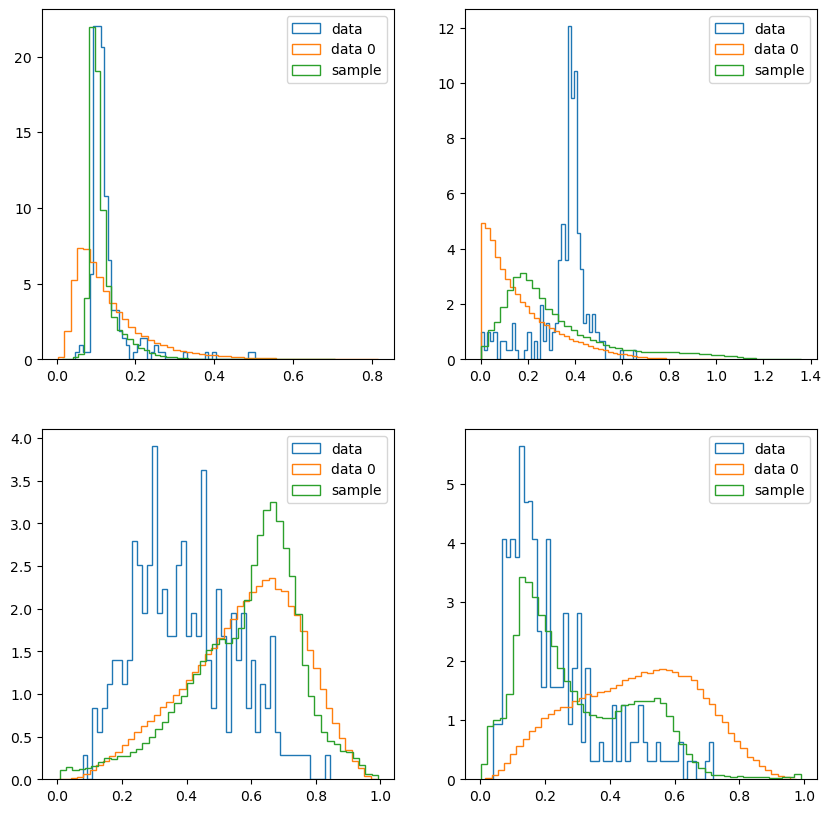

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  13 trainloss:  4.506200979477959 valloss:  2.951405797685896
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


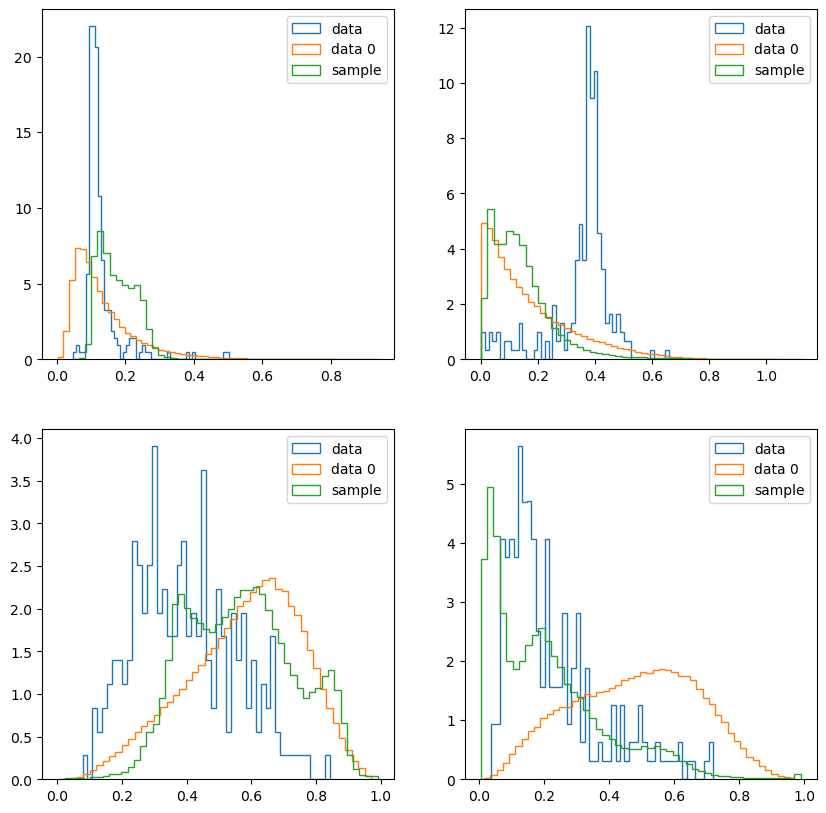

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  14 trainloss:  4.500791128424518 valloss:  2.951143155779157
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


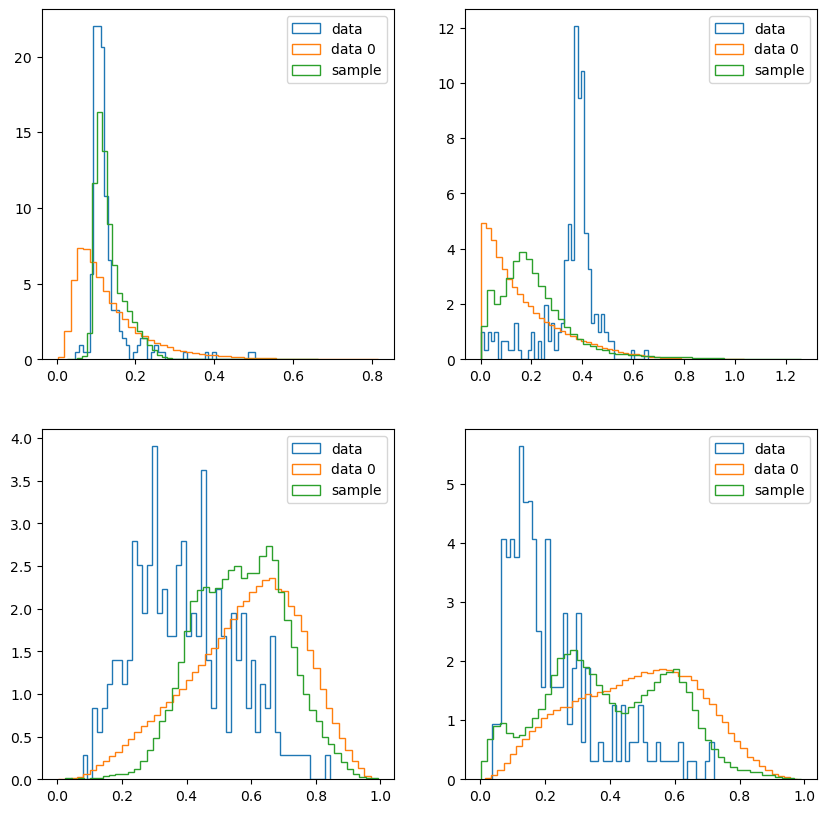

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  15 trainloss:  4.498908882307331 valloss:  2.951080799102783
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


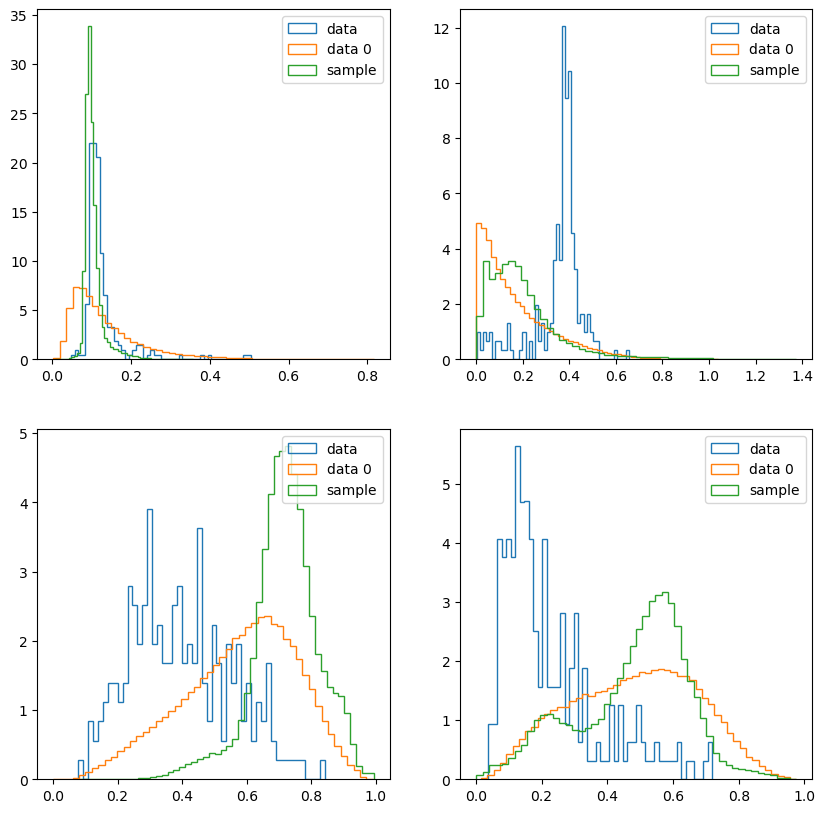

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  16 trainloss:  4.504068234387566 valloss:  2.9511650902884345
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


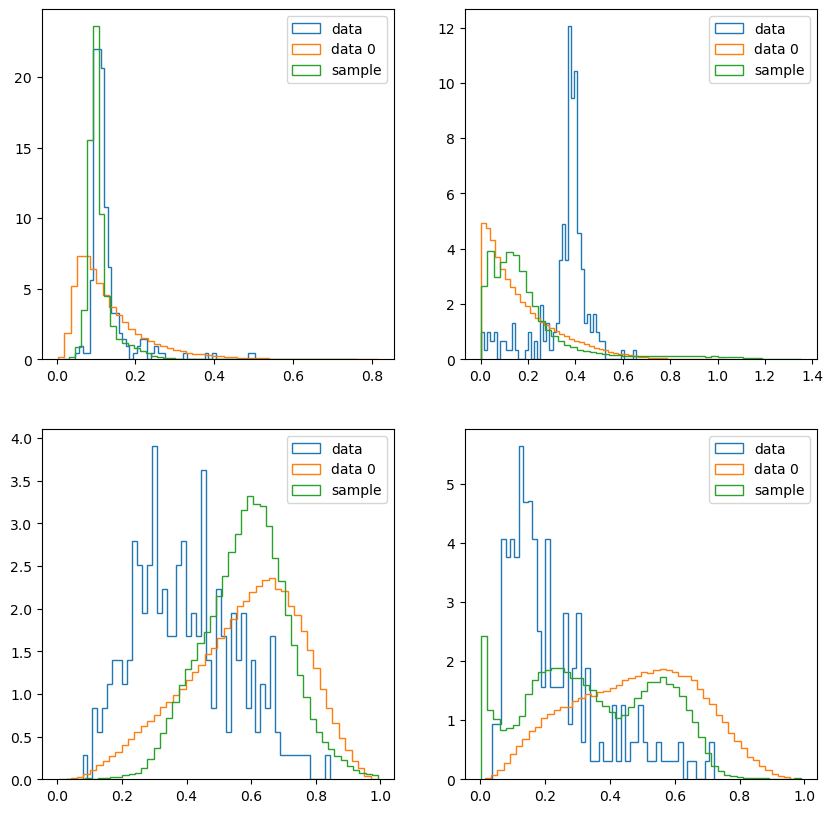

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  17 trainloss:  4.50209153451691 valloss:  2.9512297085353305
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


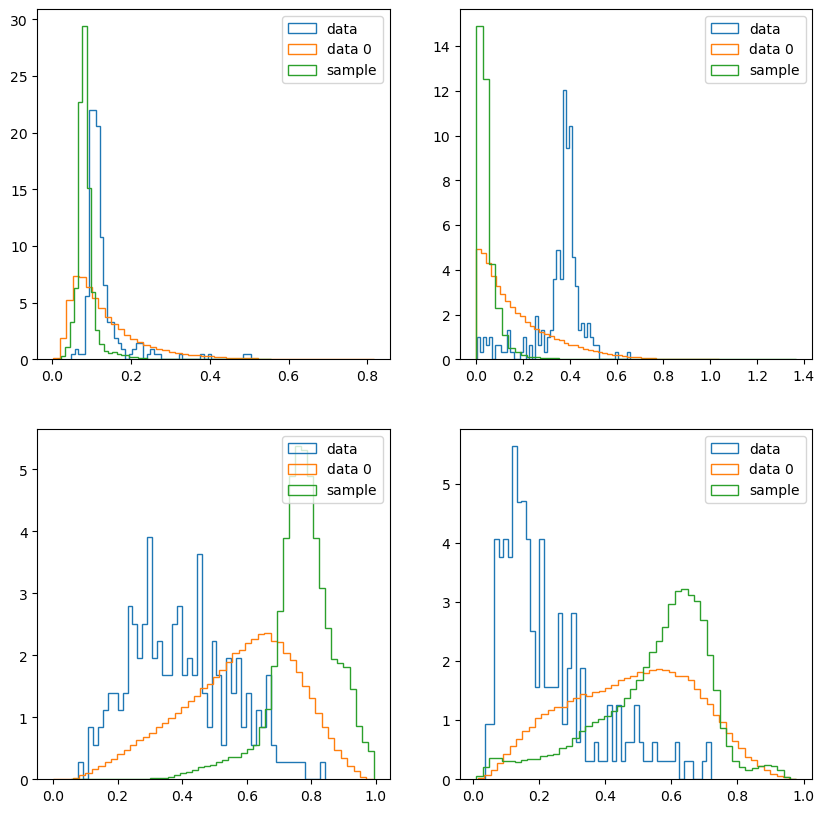

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  18 trainloss:  4.504696139582881 valloss:  2.95114780153547
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


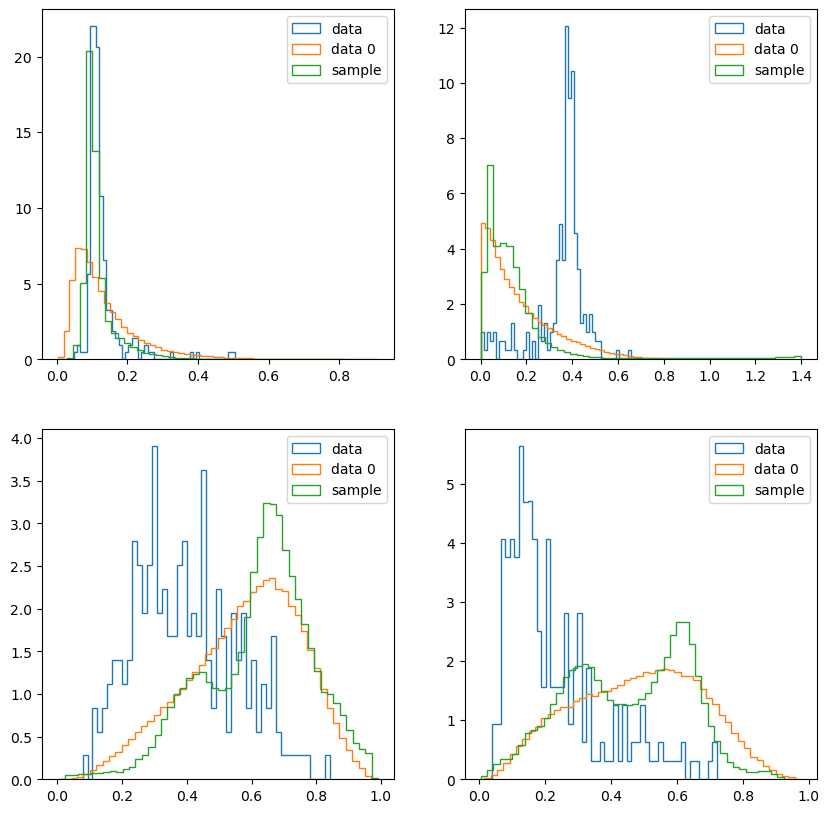

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  19 trainloss:  4.50154909329217 valloss:  2.951119204929897
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


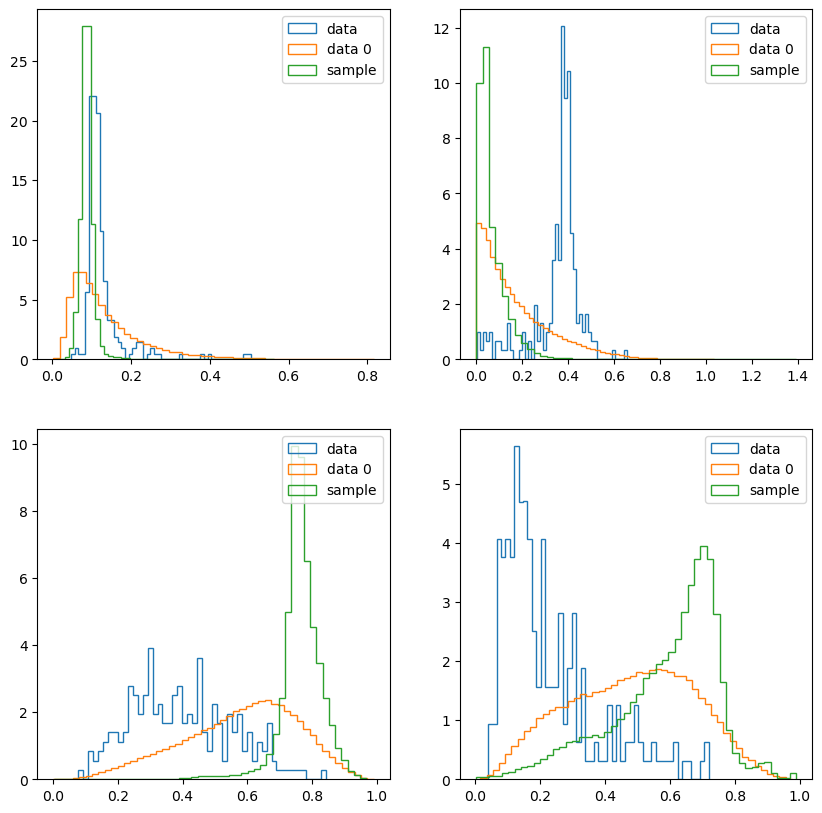

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  20 trainloss:  4.503502045841259 valloss:  2.9511194774082727
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


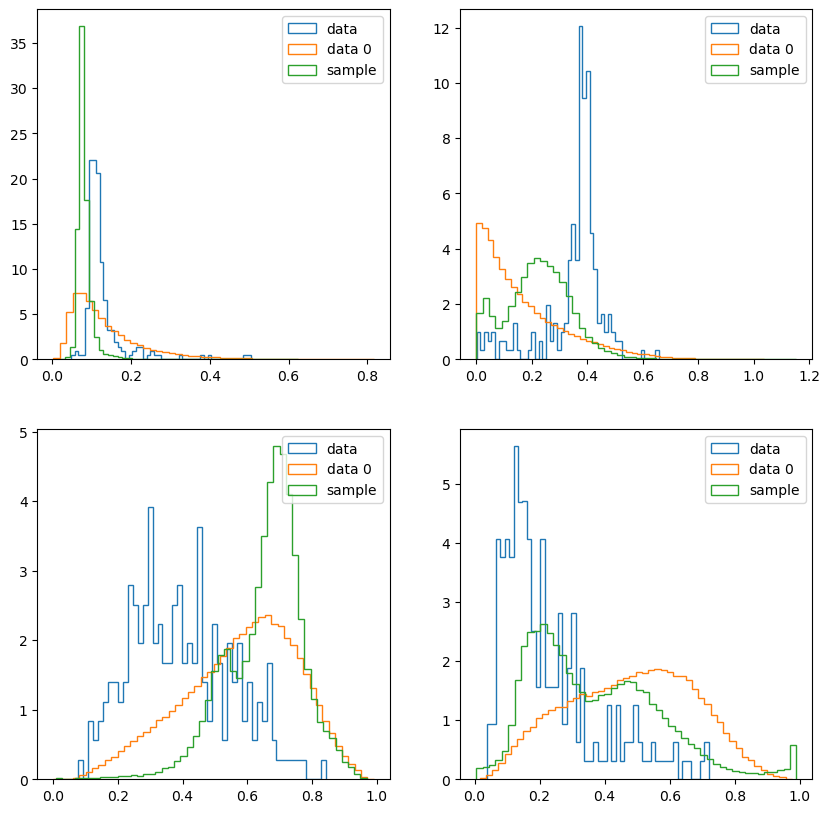

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  21 trainloss:  4.502855226105335 valloss:  2.95115692956107
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


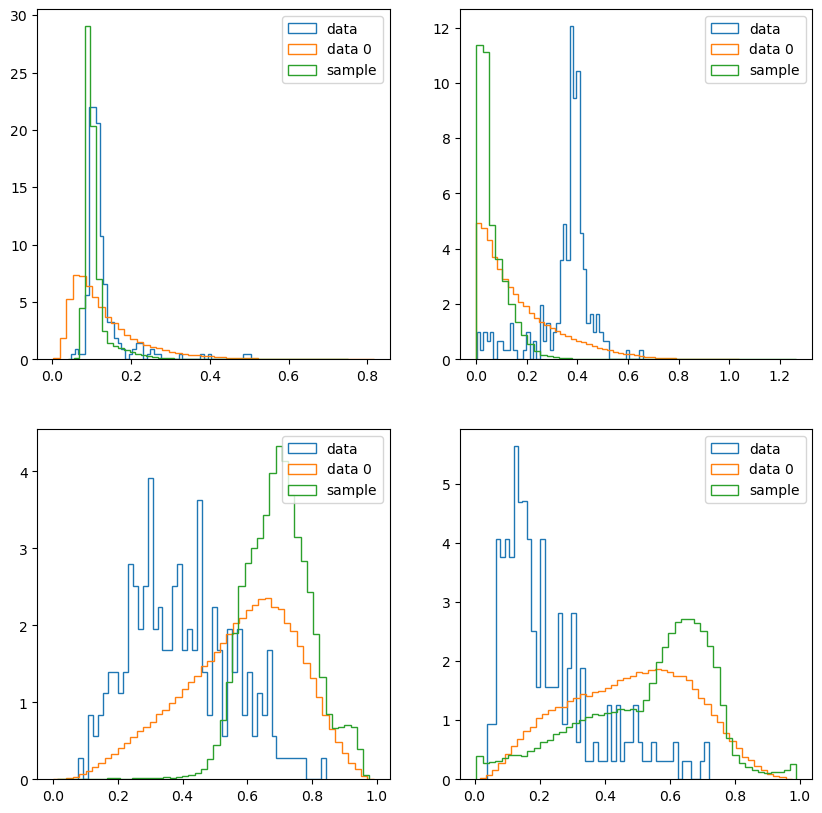

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  22 trainloss:  4.5056554102430155 valloss:  2.9514083862304688
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


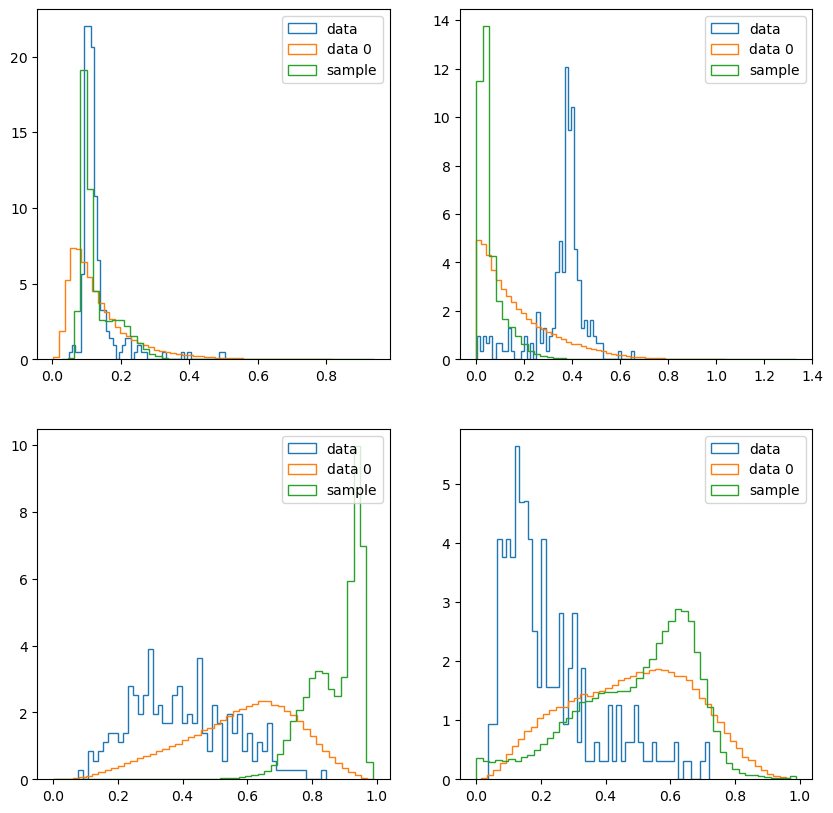

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  23 trainloss:  4.503992829707194 valloss:  2.951239381517683
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


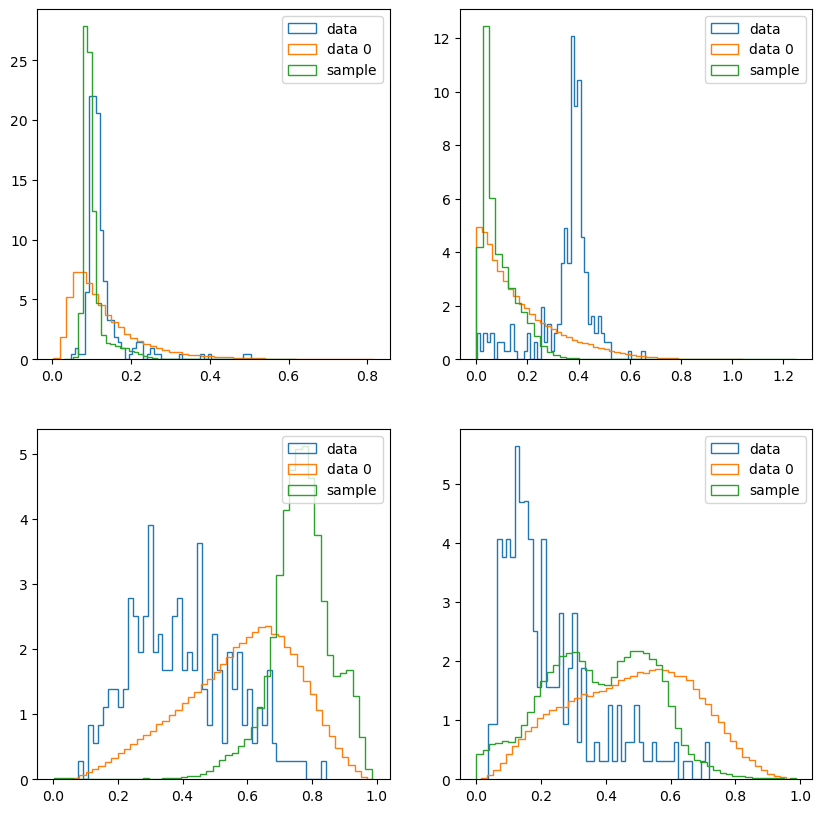

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  24 trainloss:  4.504348503478472 valloss:  2.9512186867850168
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


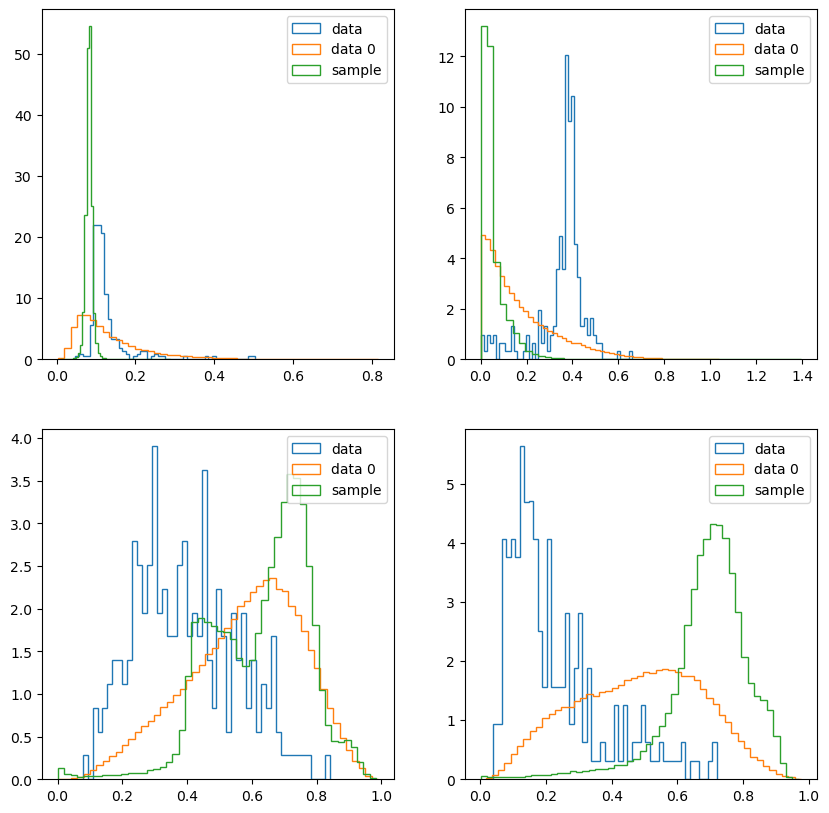

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  25 trainloss:  4.503489058002148 valloss:  2.9511260305132185
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


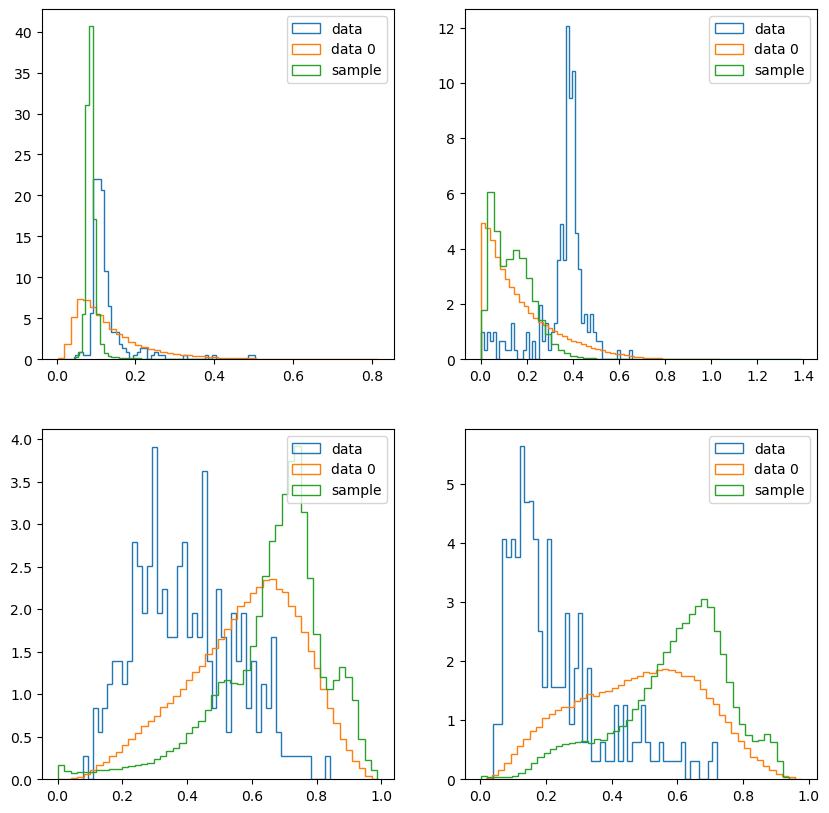

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  26 trainloss:  4.506358241203824 valloss:  2.951145076751709
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


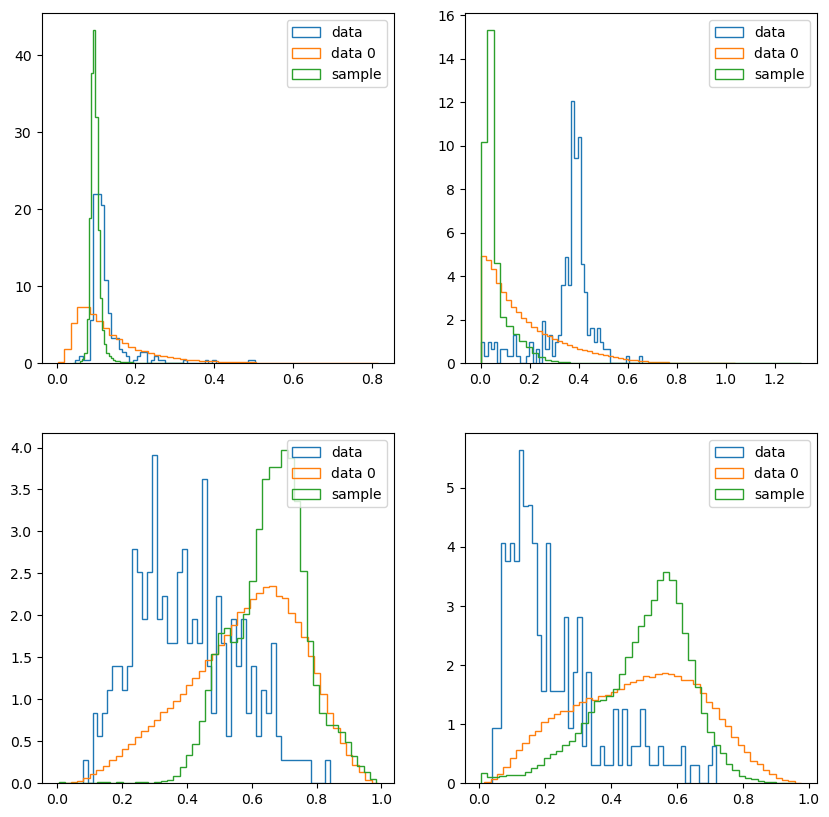

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  27 trainloss:  4.50510055774697 valloss:  2.9511942318507605
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


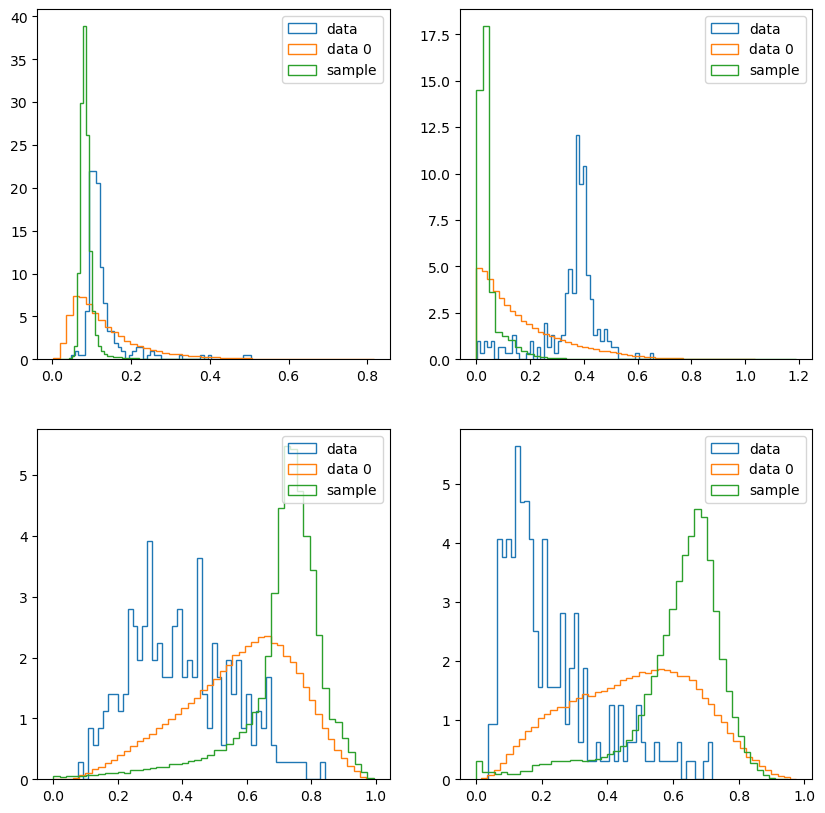

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  28 trainloss:  4.5047899092464405 valloss:  2.9511935234069826
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


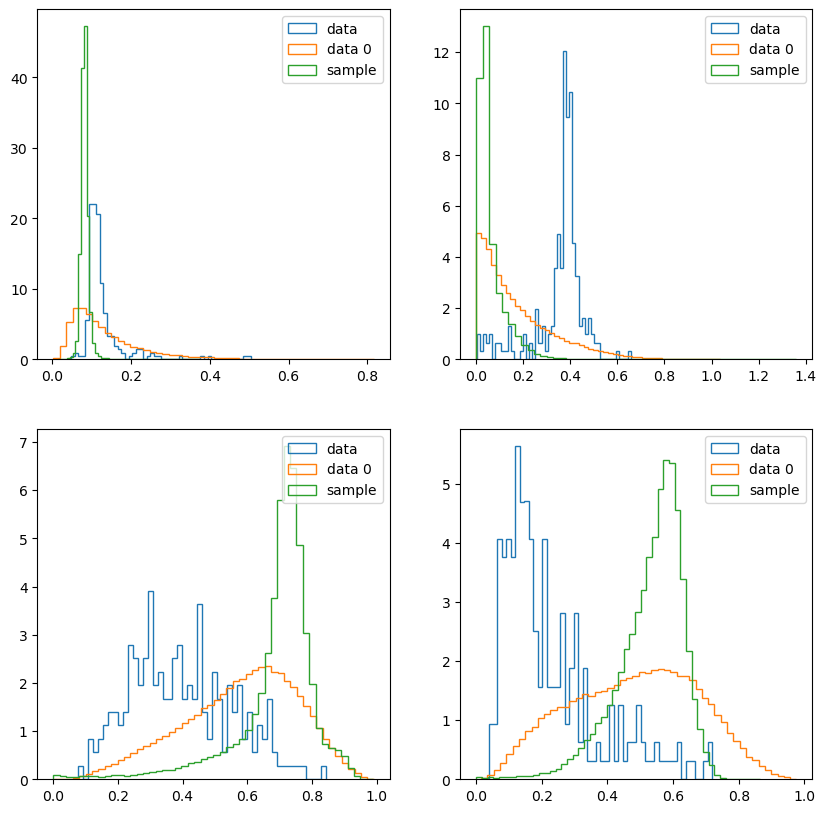

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  29 trainloss:  4.506840320454184 valloss:  2.951107392992292
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


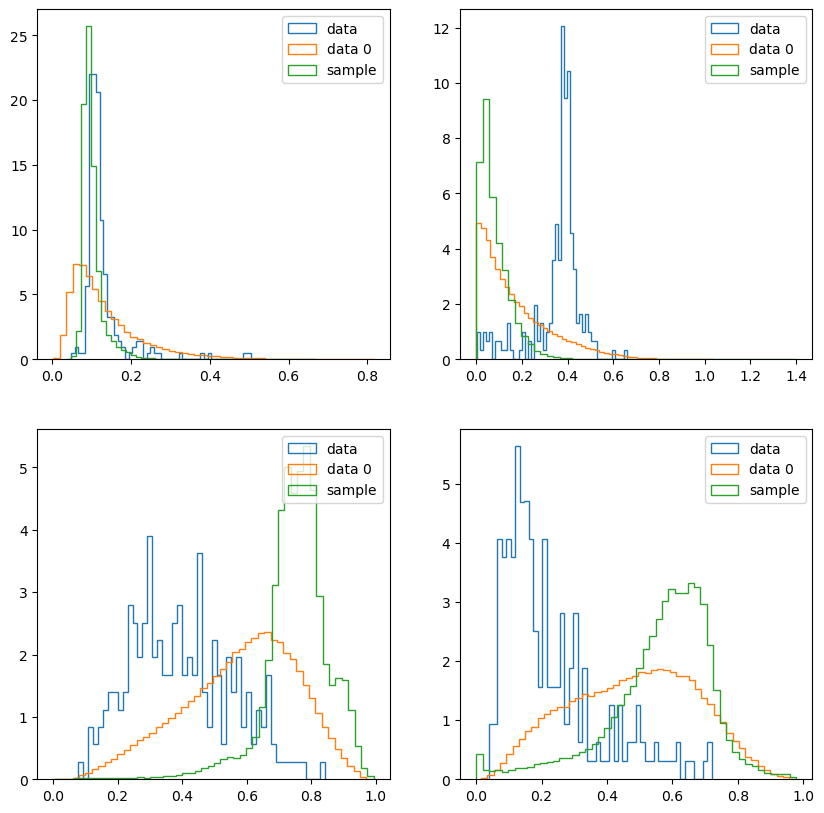

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  30 trainloss:  4.50363142557913 valloss:  2.9511648178100587
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


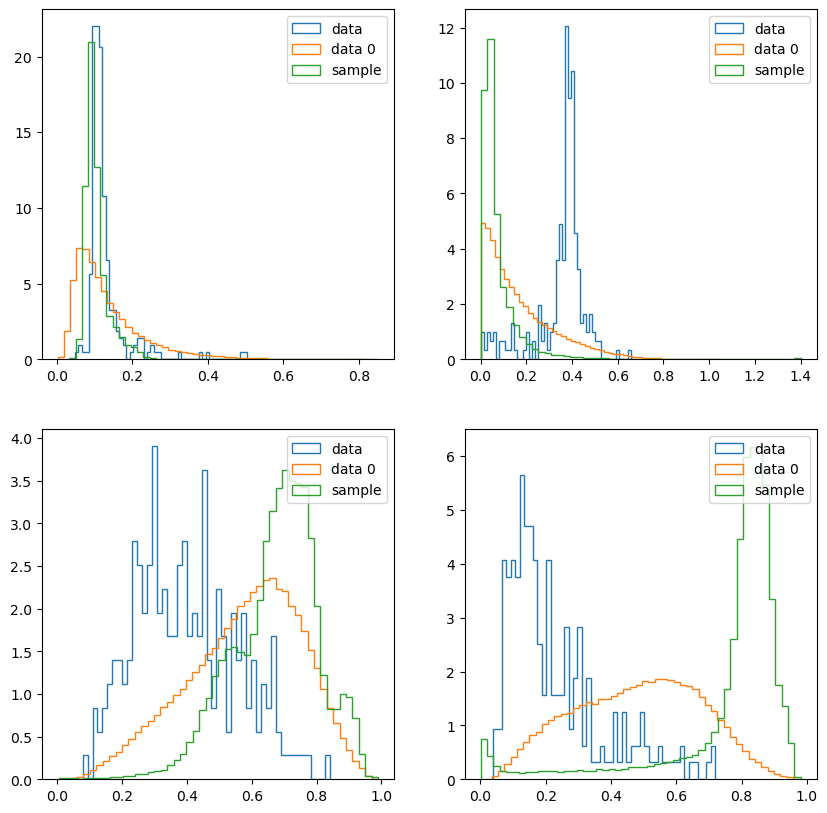

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  31 trainloss:  4.502817490002169 valloss:  2.951105390276228
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


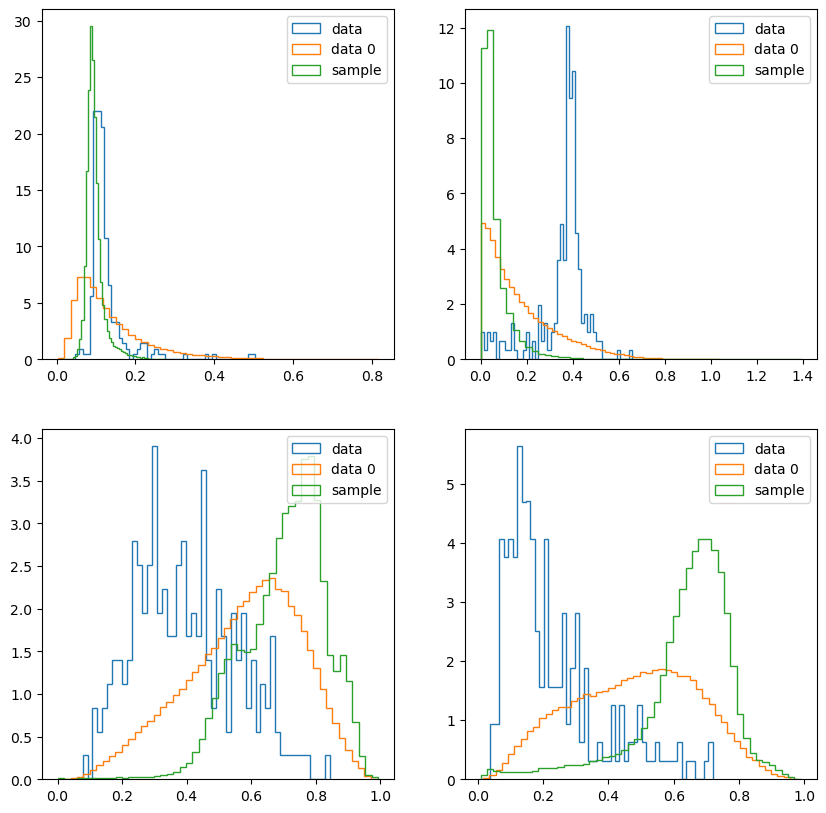

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  32 trainloss:  4.505249302891085 valloss:  2.9511428560529436
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


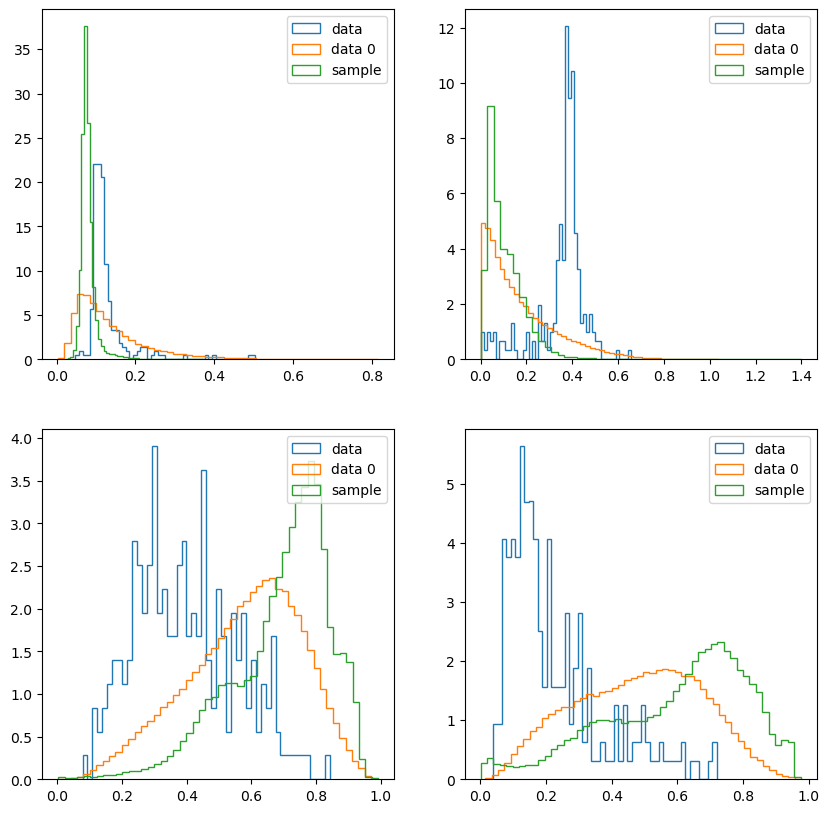

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  33 trainloss:  4.505263016893973 valloss:  2.951187937600272
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


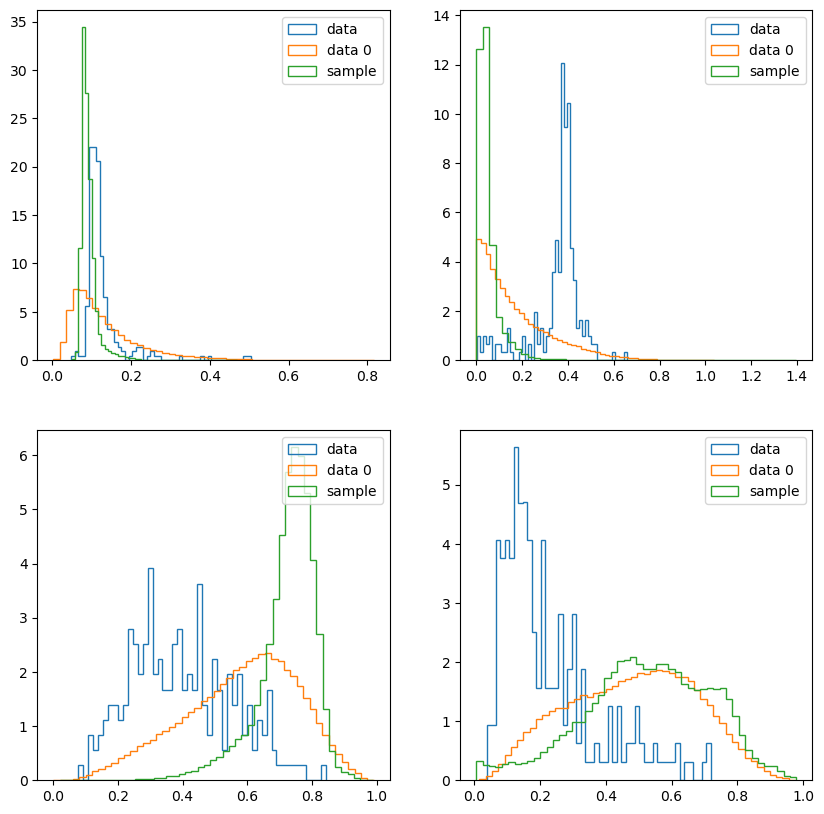

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  34 trainloss:  4.505308691452791 valloss:  2.9511469841003417
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


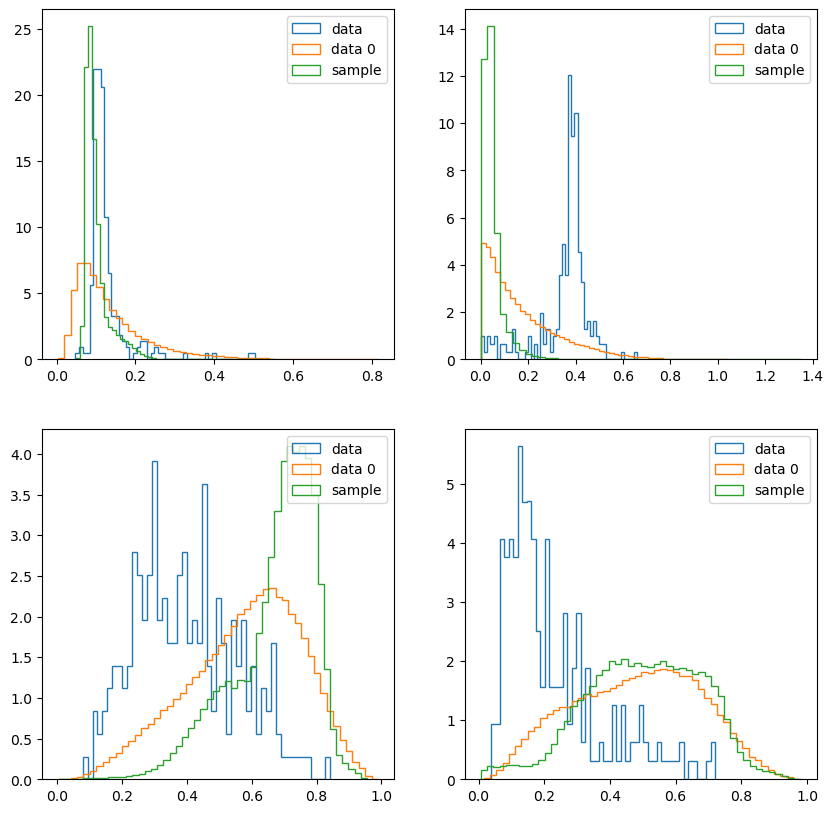

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  35 trainloss:  4.503486329953395 valloss:  2.951132924216134
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


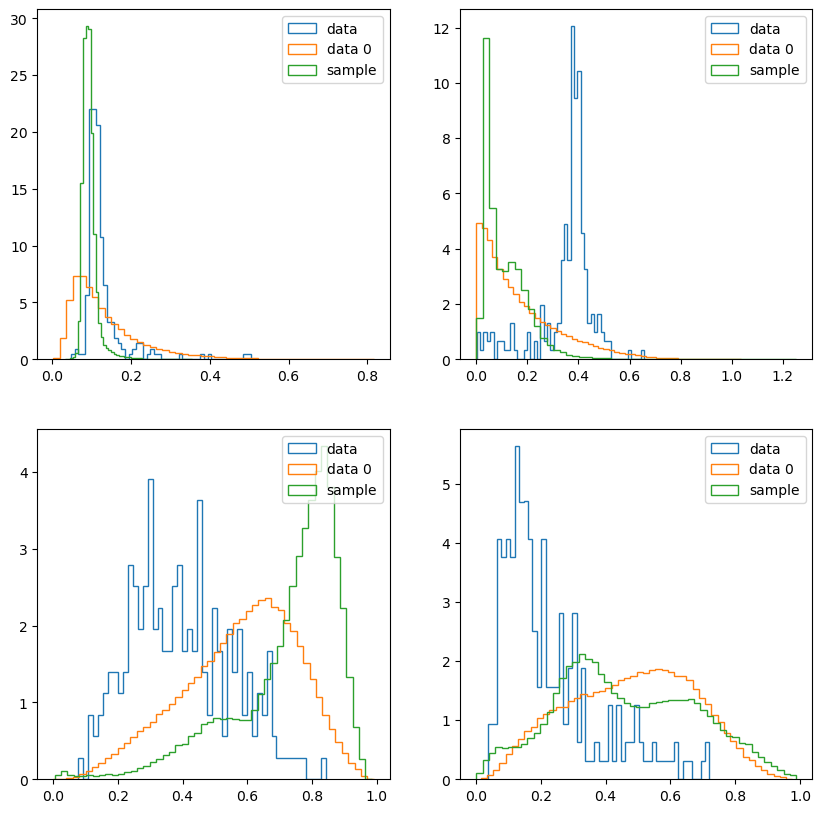

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  36 trainloss:  4.505430515555255 valloss:  2.9511344364711216
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


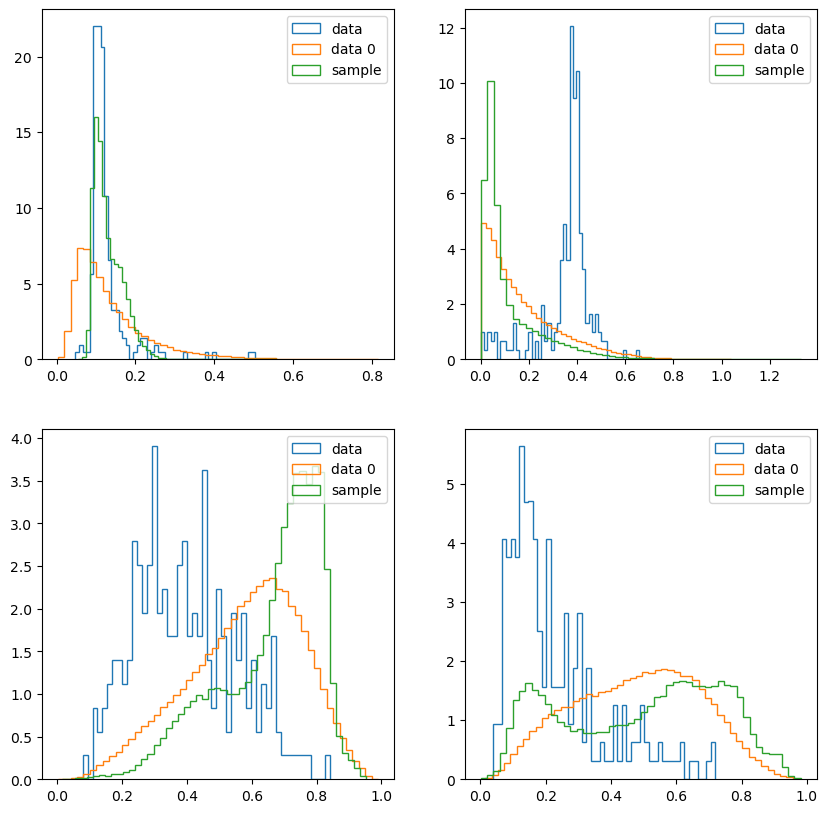

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  37 trainloss:  4.50328077989466 valloss:  2.9511632919311523
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


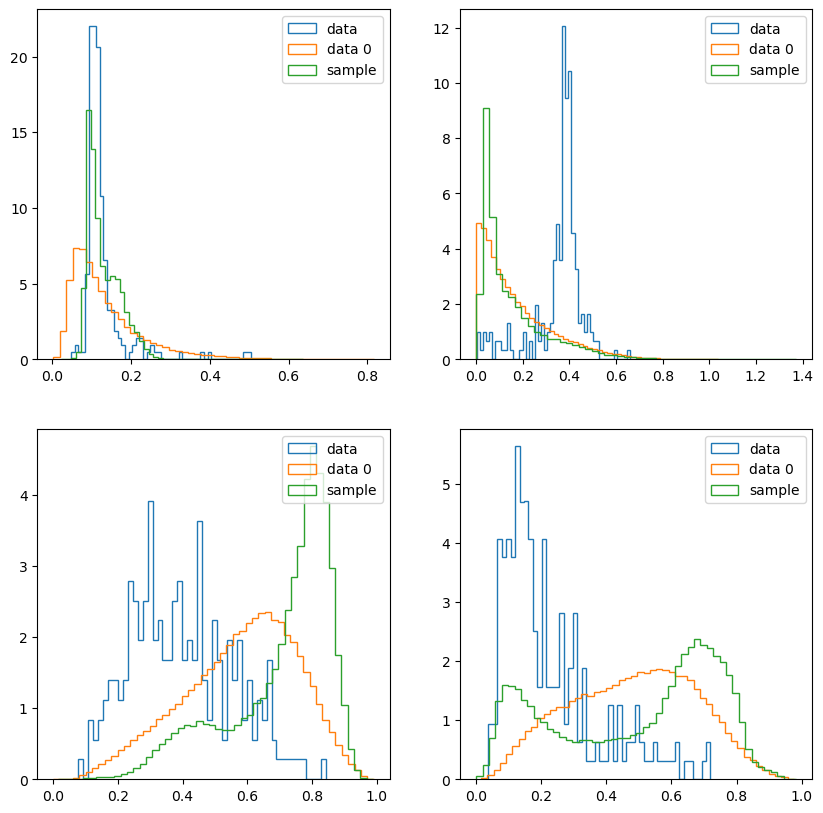

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  38 trainloss:  4.499141010583616 valloss:  2.951107052394322
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


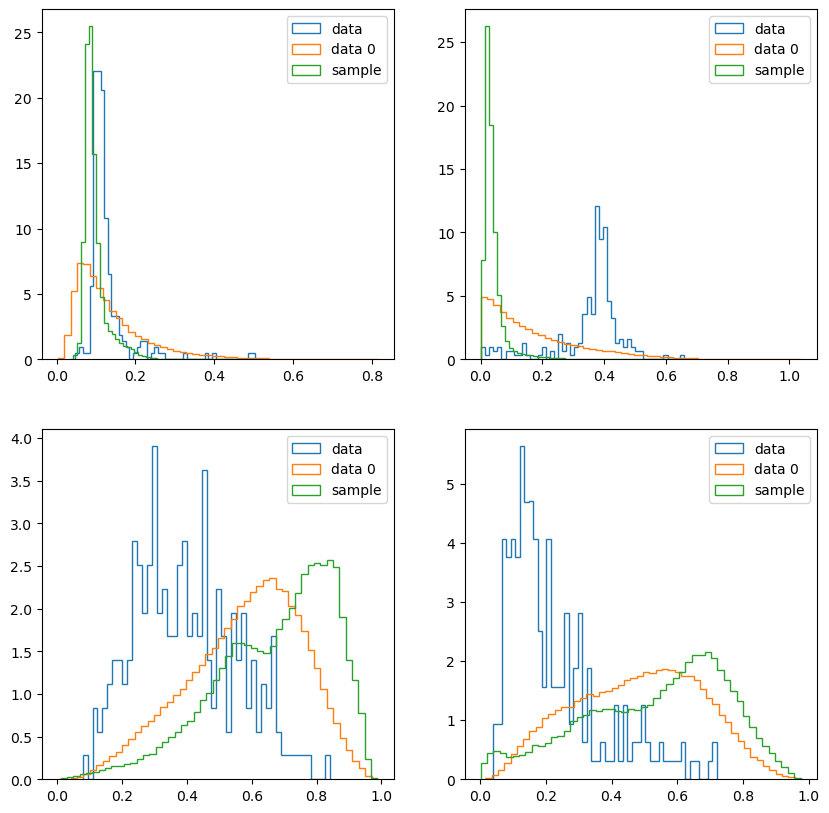

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  39 trainloss:  4.500315515563899 valloss:  2.951046289716448
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


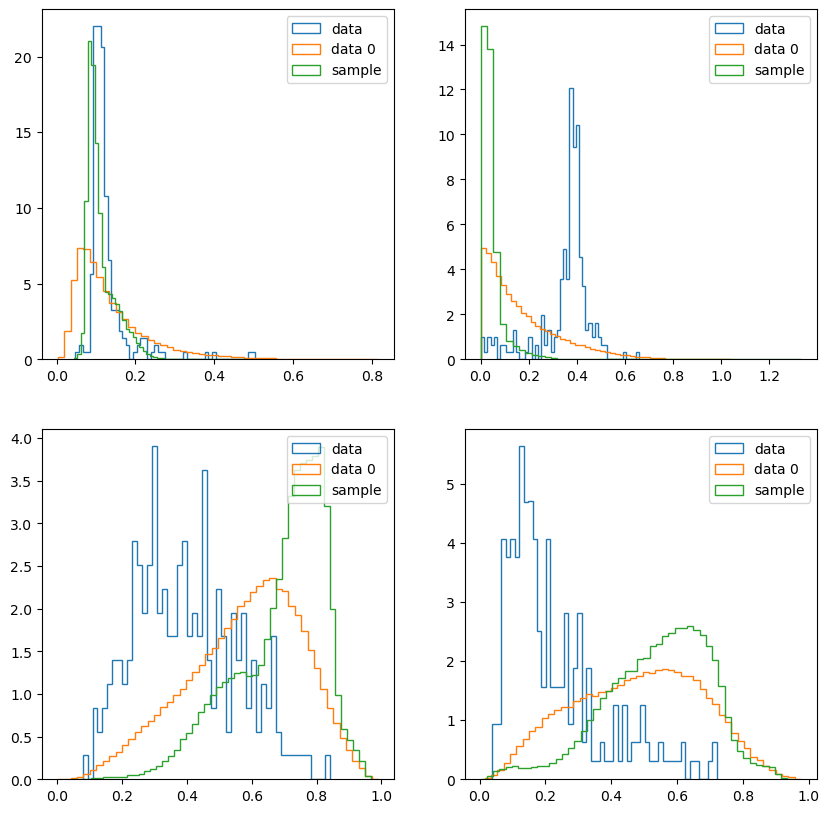

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  40 trainloss:  4.5026572810279 valloss:  2.9510643550327846
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


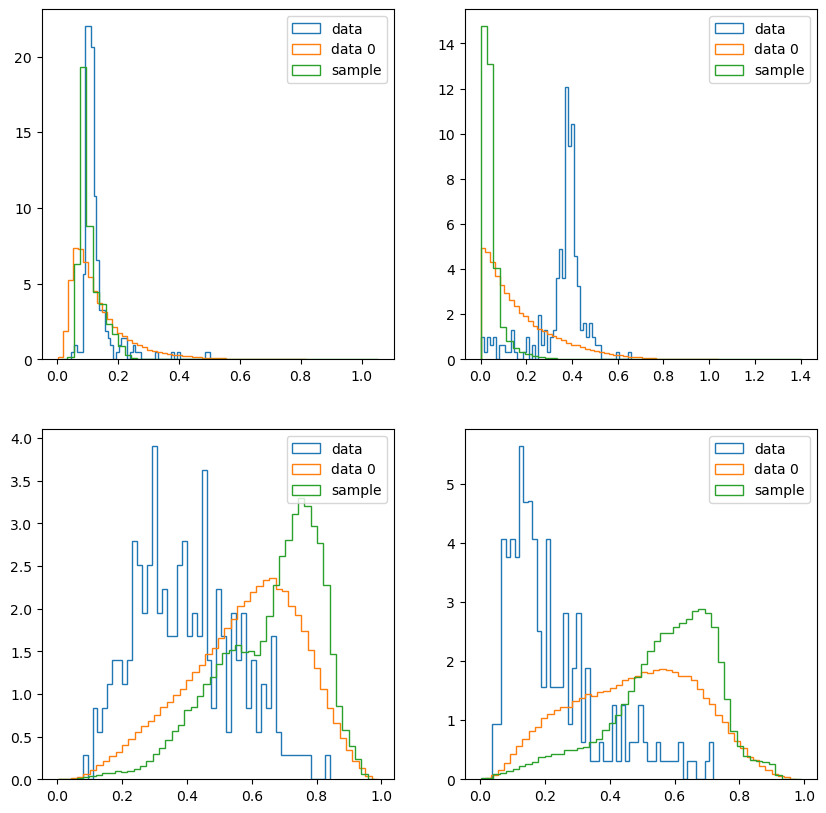

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  41 trainloss:  4.502568588797043 valloss:  2.951052965436663
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


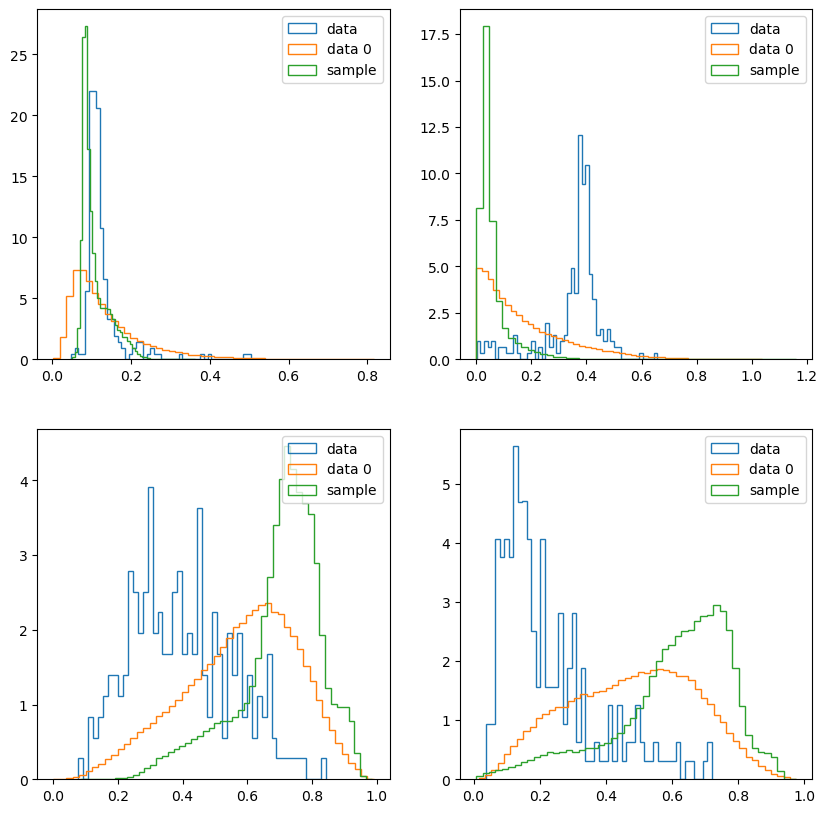

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  42 trainloss:  4.505268257947269 valloss:  2.9511021477835517
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


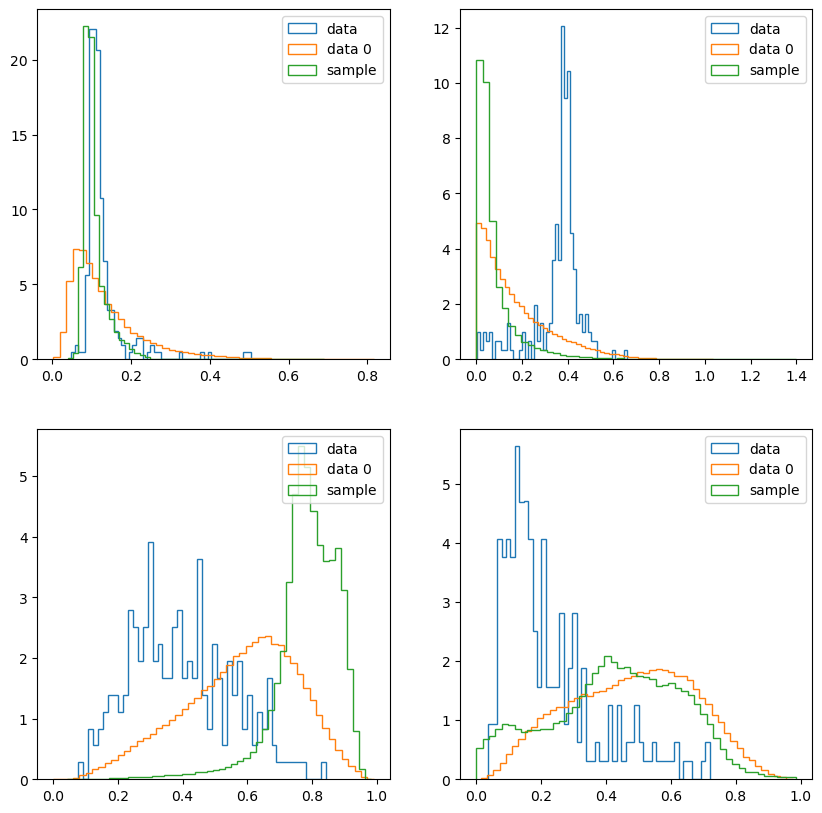

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  43 trainloss:  4.504134503844517 valloss:  2.9511165346418107
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


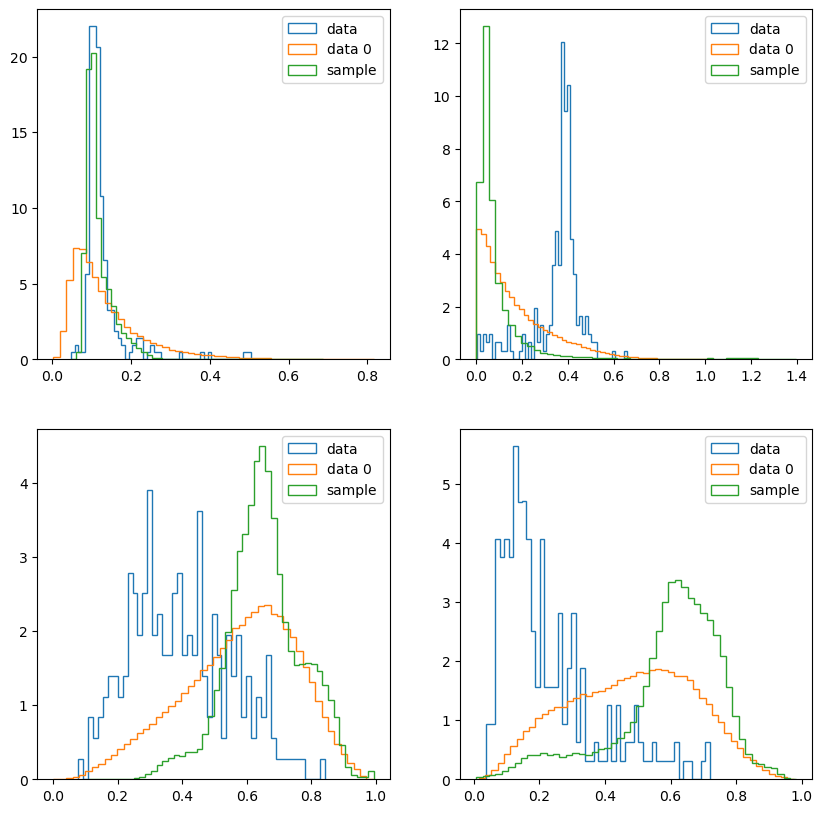

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  44 trainloss:  4.502375553895705 valloss:  2.9510817664010185
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


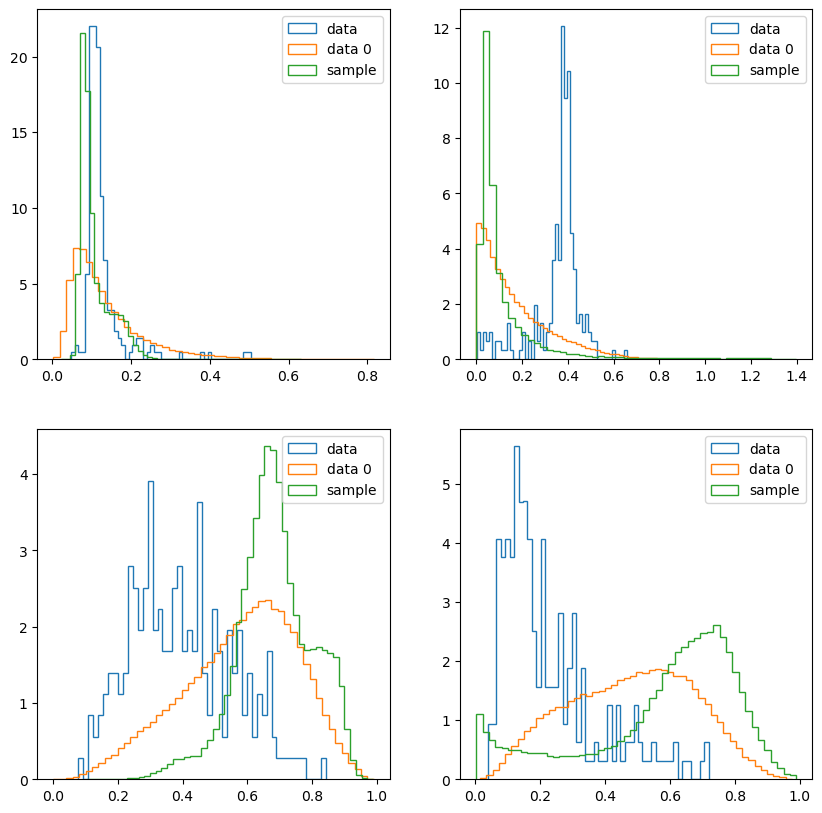

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  45 trainloss:  4.504685240893063 valloss:  2.9511393002101354
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


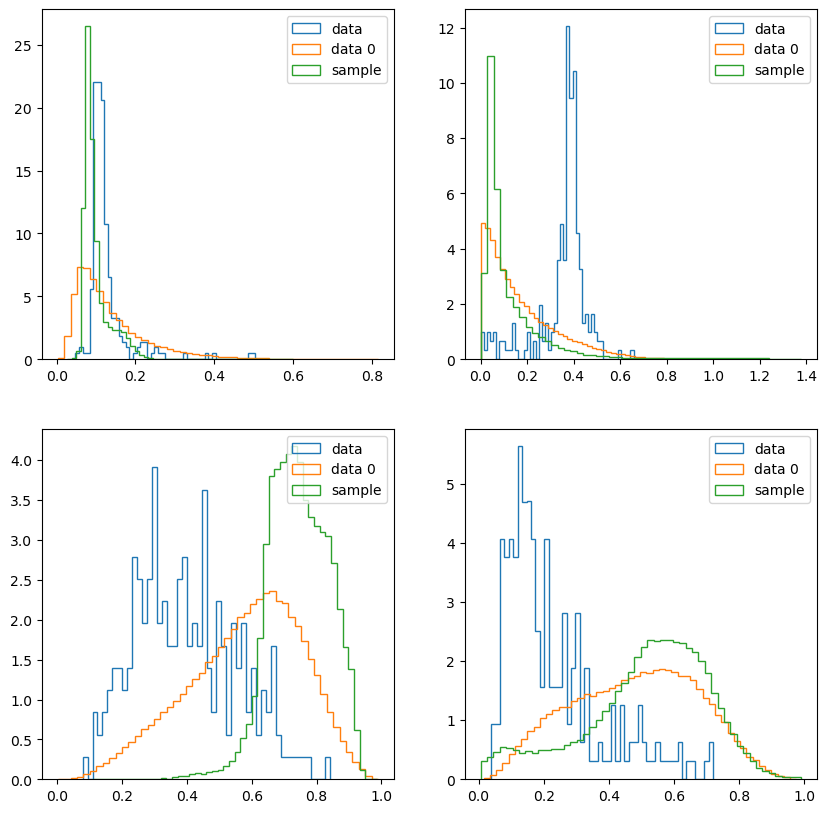

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  46 trainloss:  4.506435724125448 valloss:  2.951124450138637
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


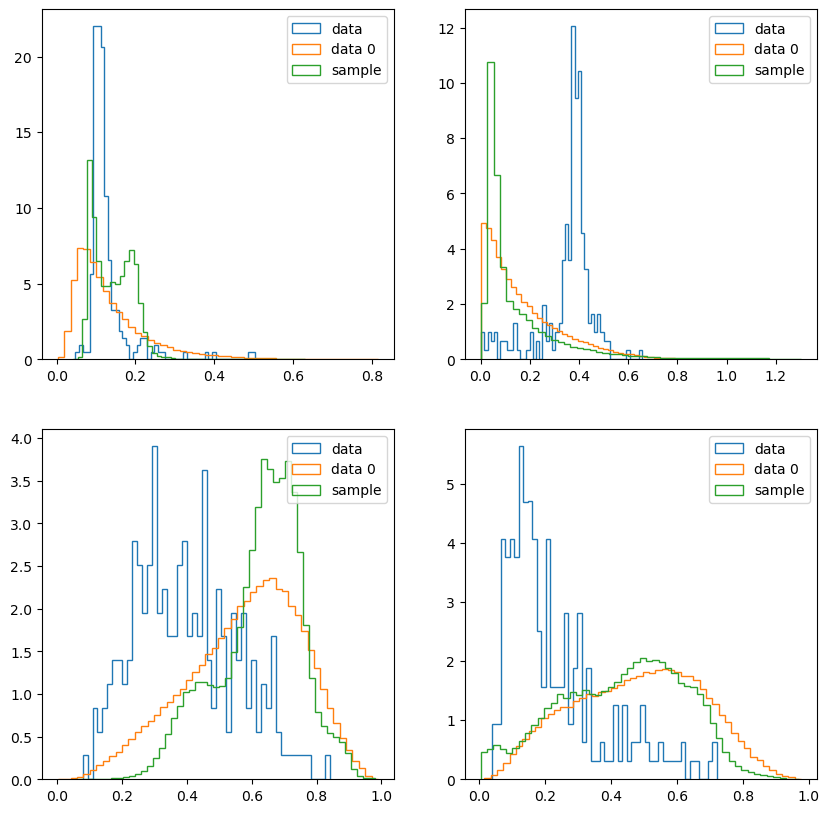

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  47 trainloss:  4.503208828907387 valloss:  2.9510885102408273
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


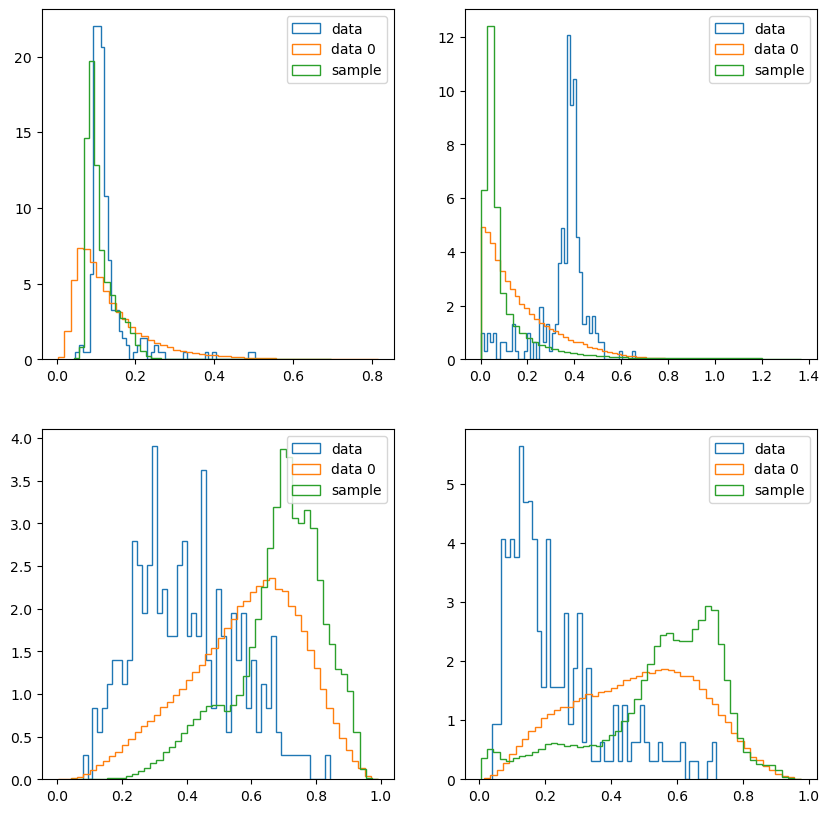

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  48 trainloss:  4.504171856608006 valloss:  2.951119804382324
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


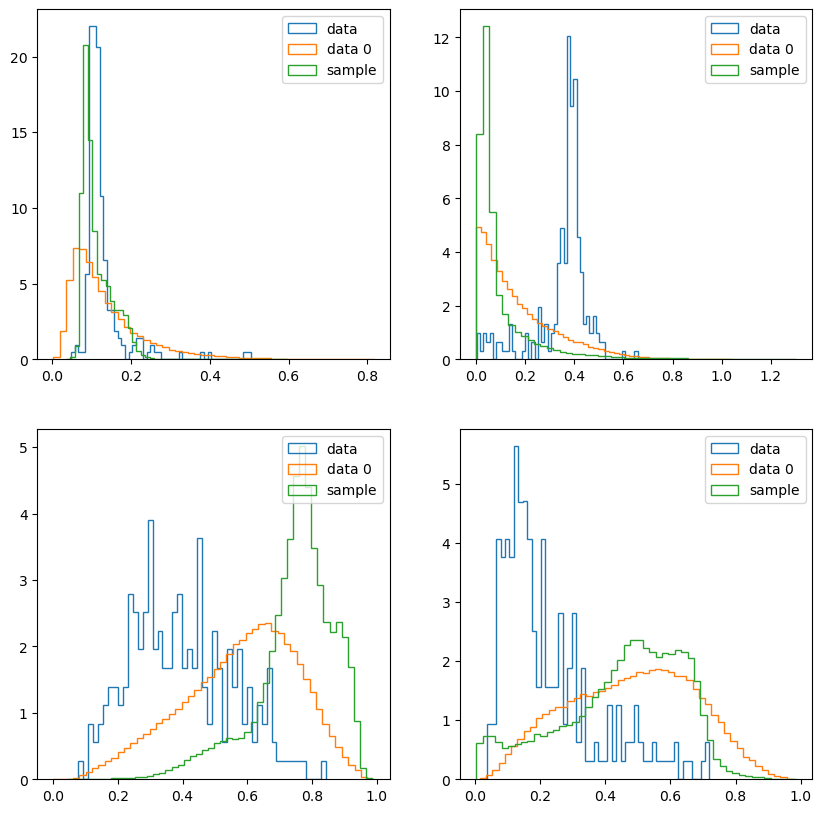

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  49 trainloss:  4.501807797708283 valloss:  2.951125635419573
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


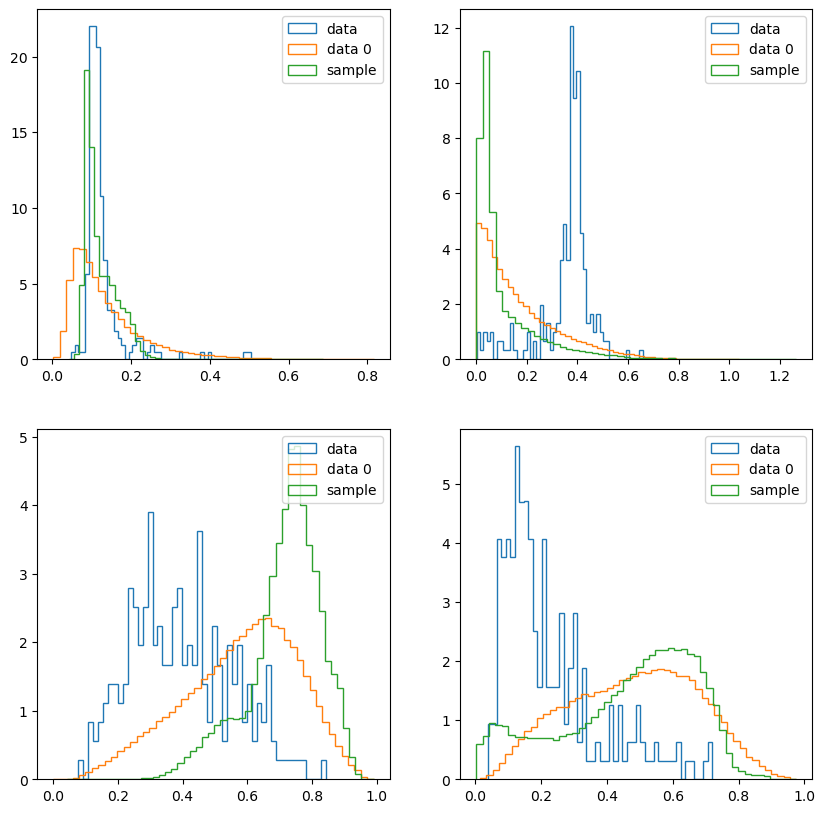

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  50 trainloss:  4.504324448654075 valloss:  2.951088183266776
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


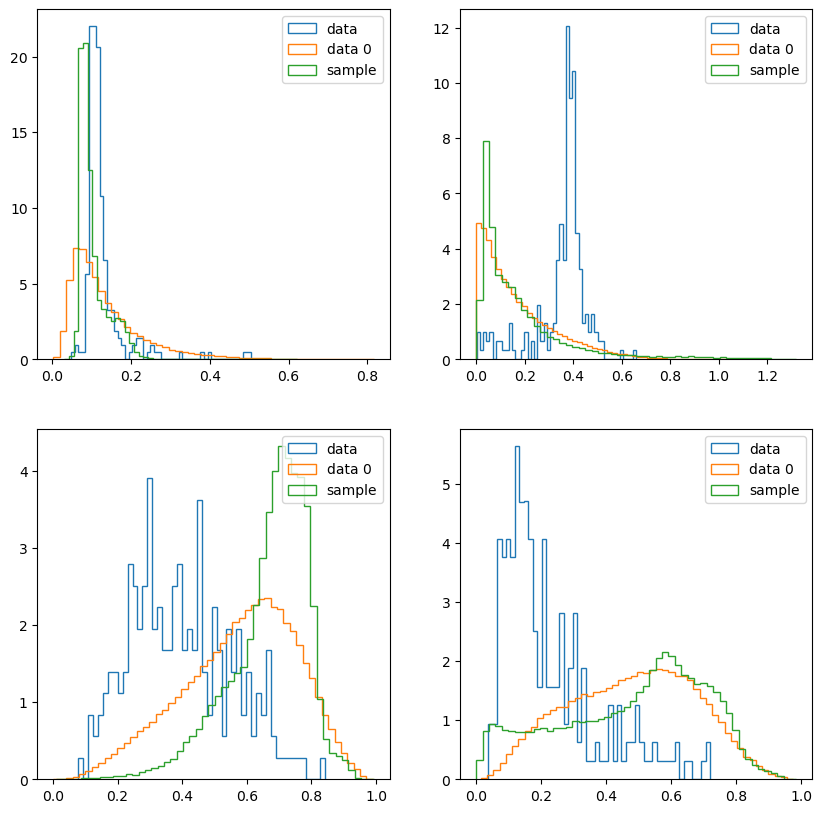

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  51 trainloss:  4.502754645669642 valloss:  2.9510625430515836
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


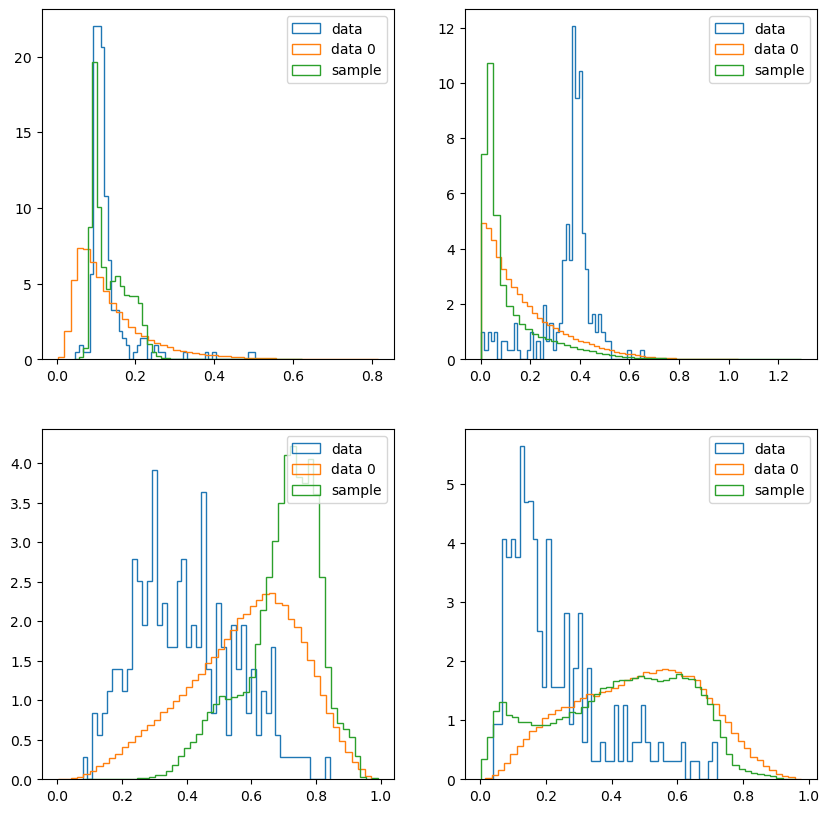

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  52 trainloss:  4.5037423904684895 valloss:  2.9511020387922016
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


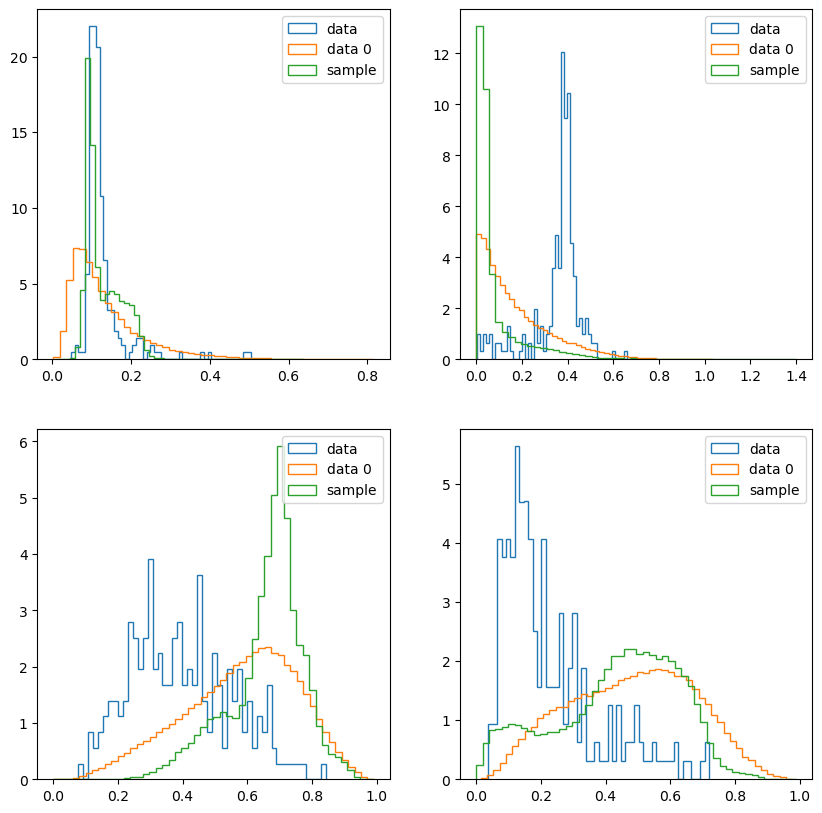

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  53 trainloss:  4.504911576480907 valloss:  2.9510525839669364
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


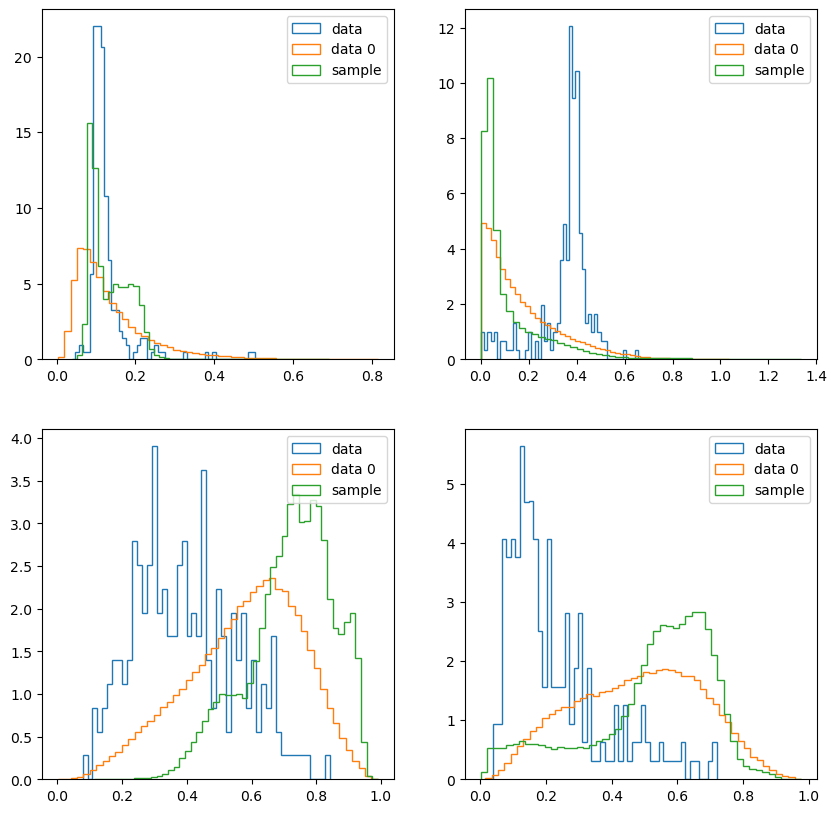

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  54 trainloss:  4.500953938187077 valloss:  2.9510873794555663
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


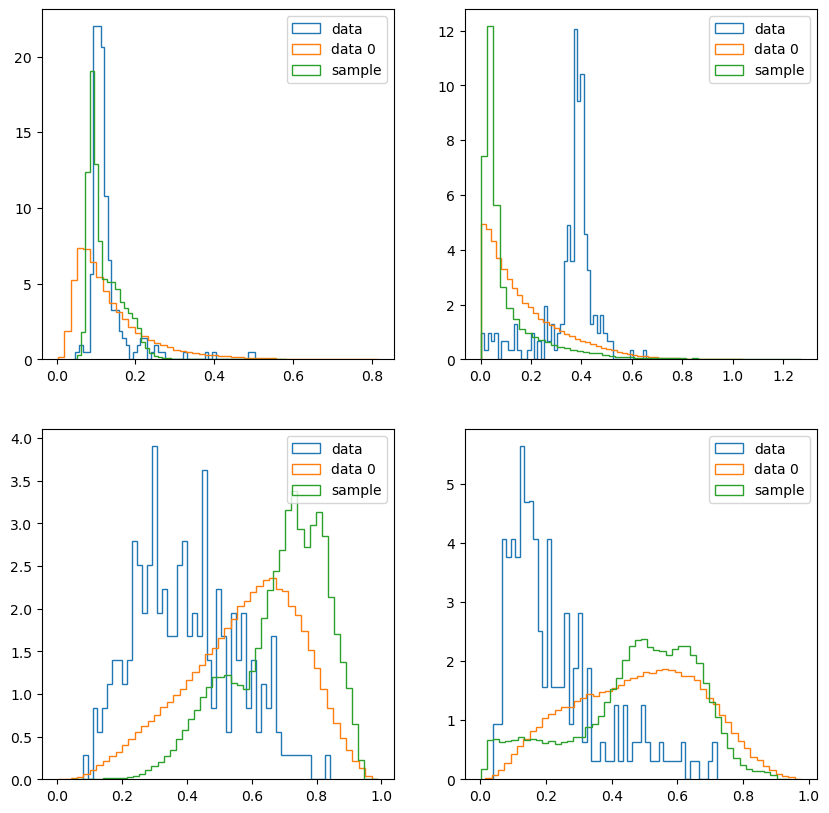

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  55 trainloss:  4.505080069332081 valloss:  2.9510872568402973
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


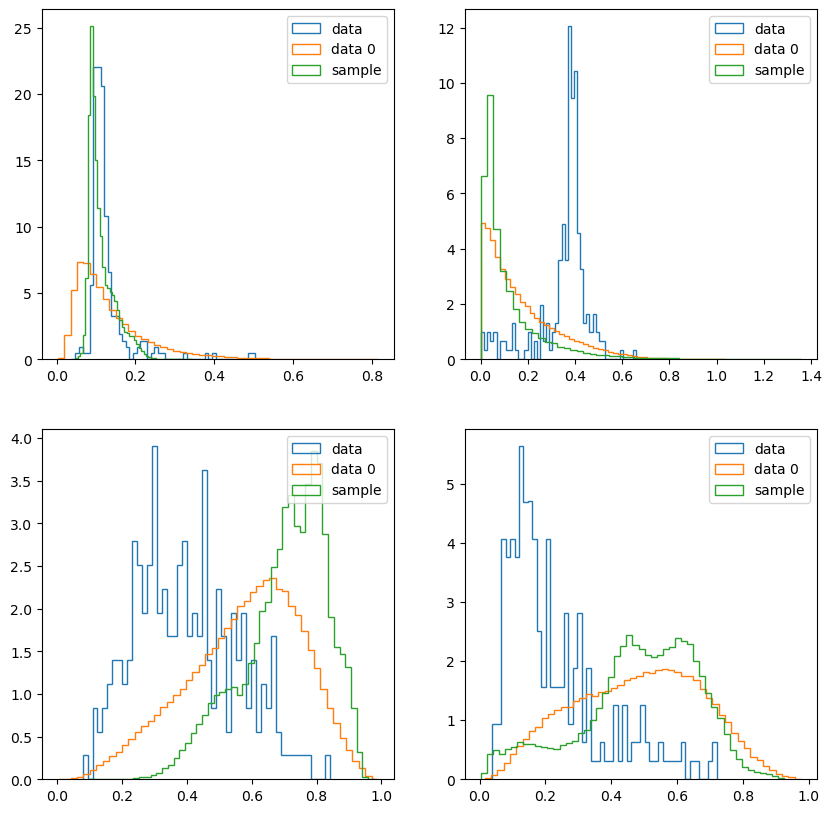

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  56 trainloss:  4.503566079150098 valloss:  2.9511110850742885
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


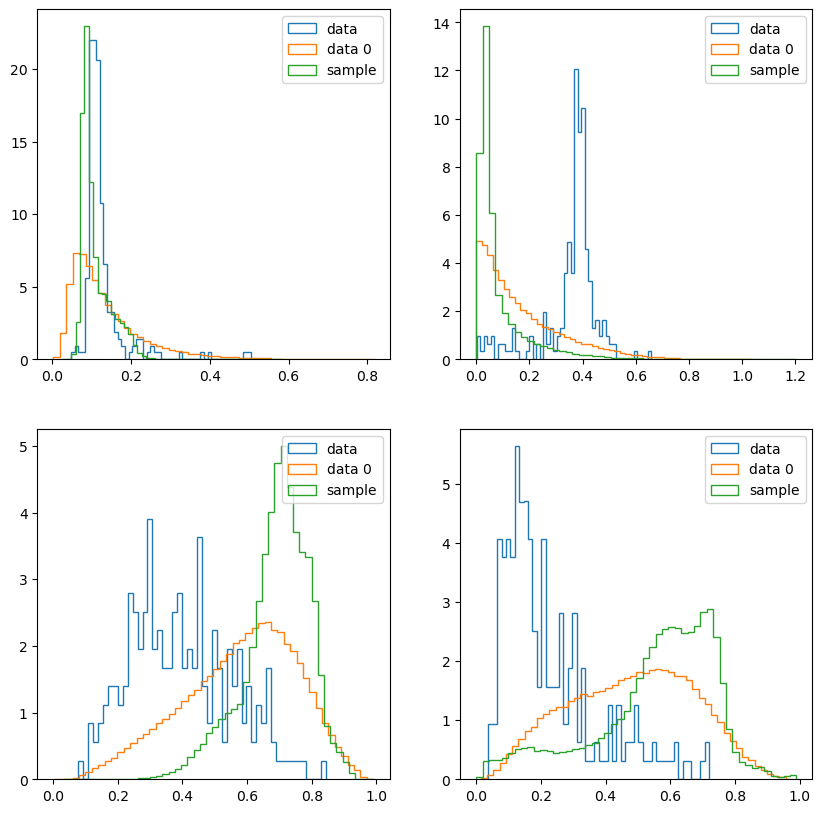

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  57 trainloss:  4.503067166197534 valloss:  2.9510871478489467
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


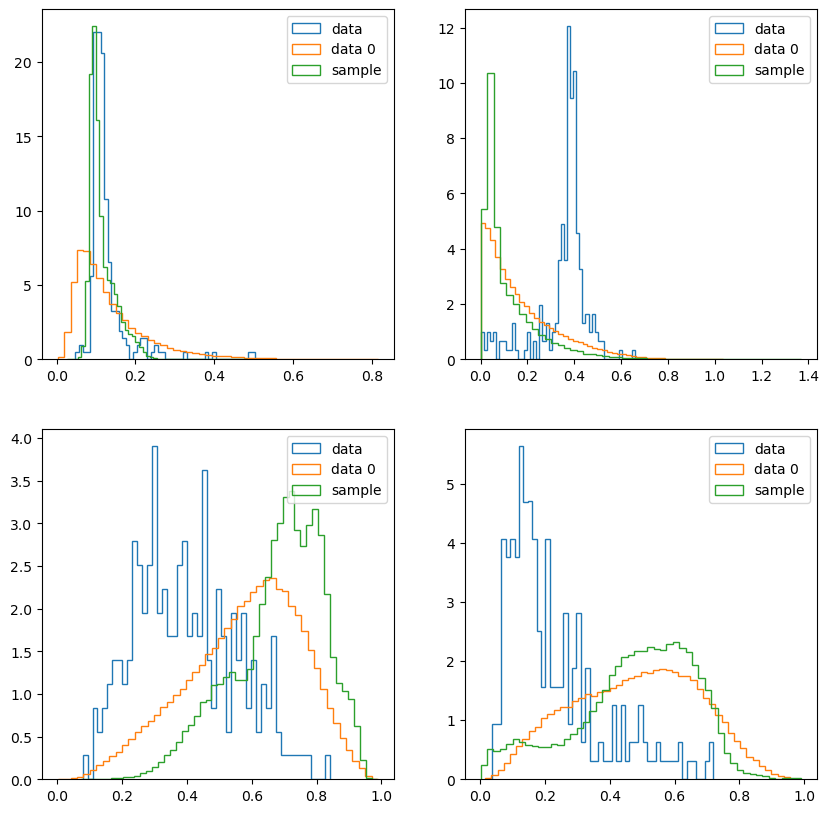

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  58 trainloss:  4.504292364473696 valloss:  2.951108877999442
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


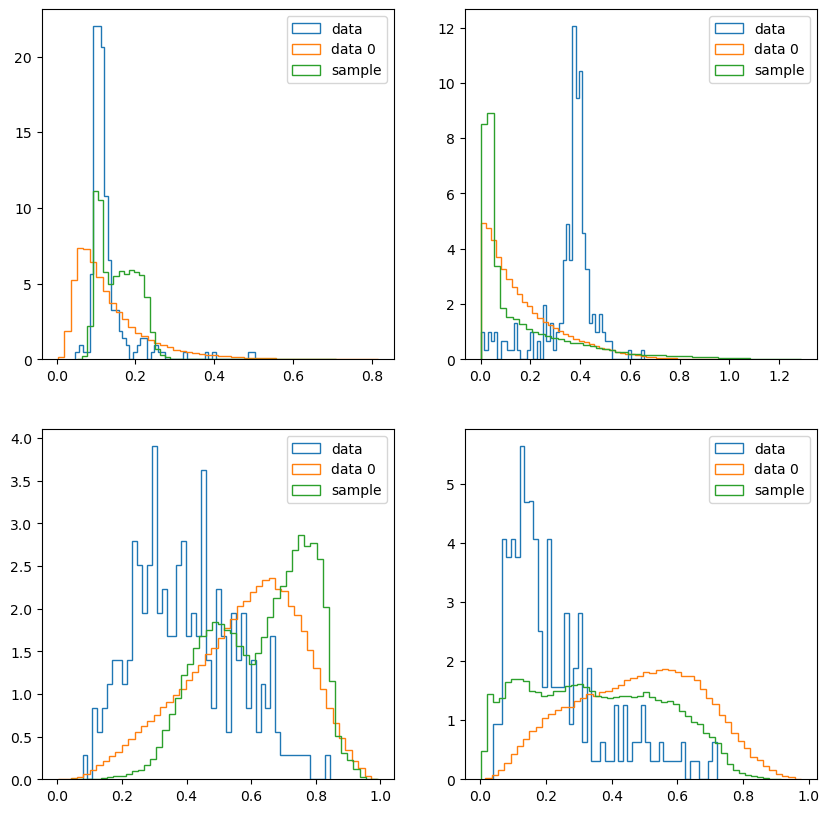

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  59 trainloss:  4.502568784102895 valloss:  2.95111517224993
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


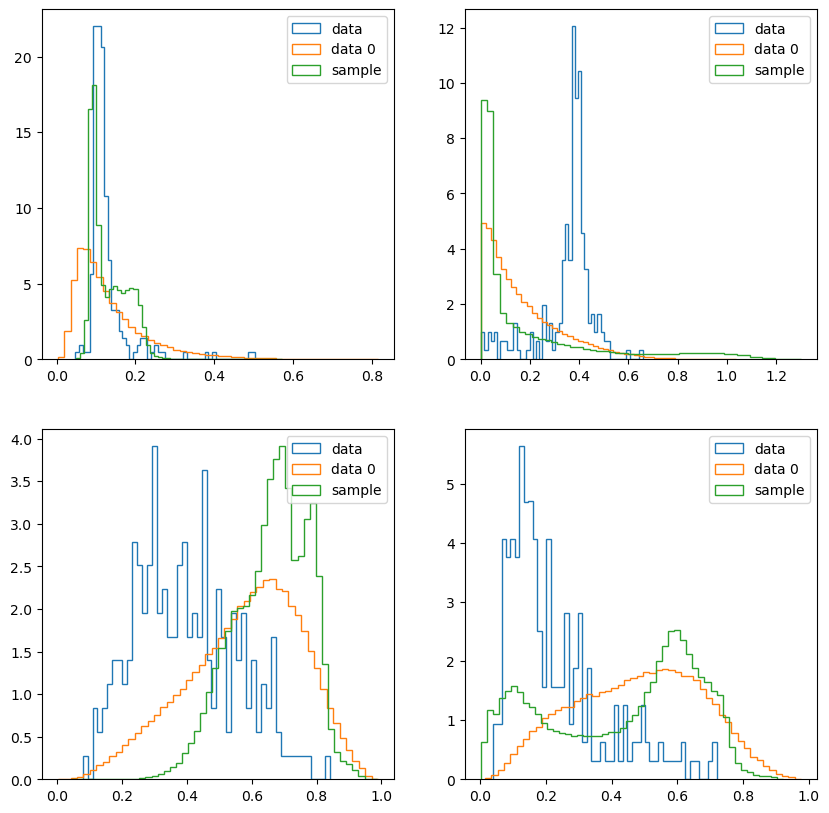

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  60 trainloss:  4.50436385992046 valloss:  2.9510939189365932
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


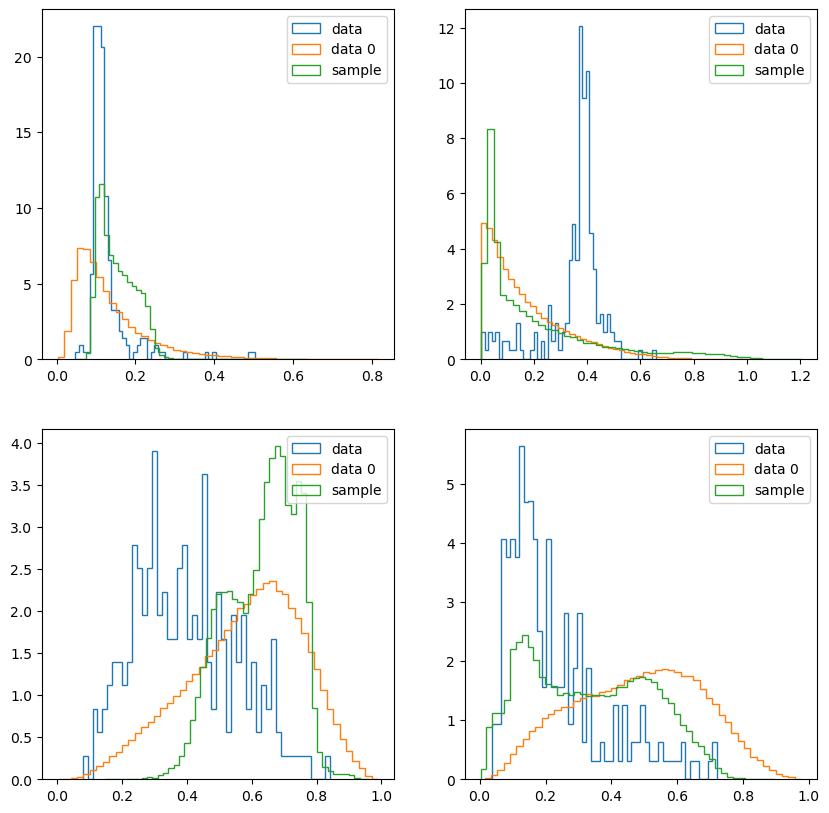

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  61 trainloss:  4.50557517901485 valloss:  2.951149204799107
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


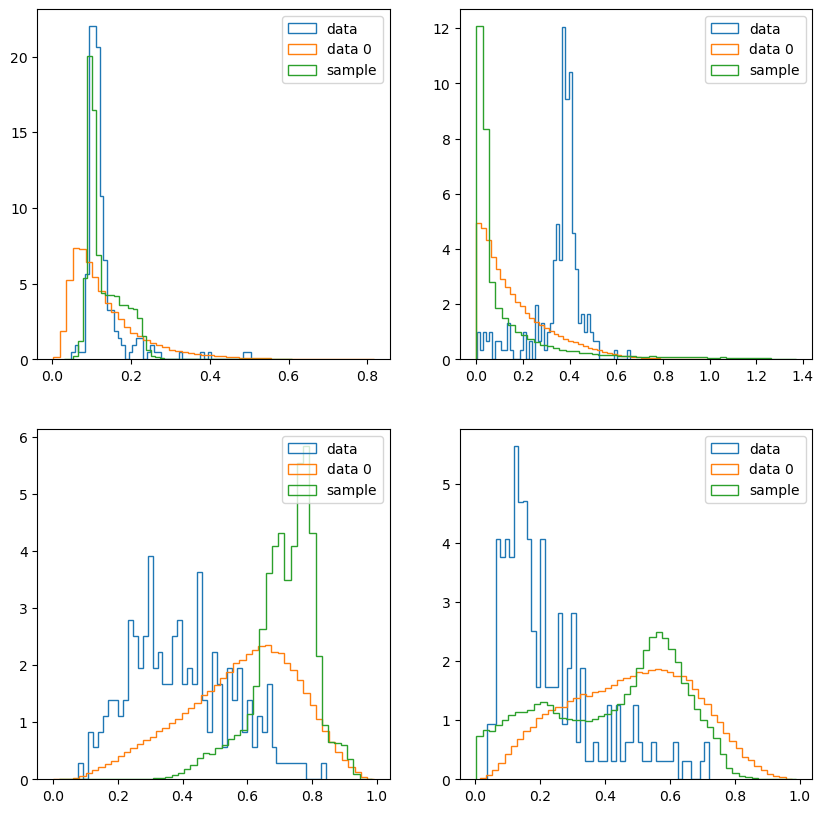

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  62 trainloss:  4.5020982128342775 valloss:  2.951133619035993
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


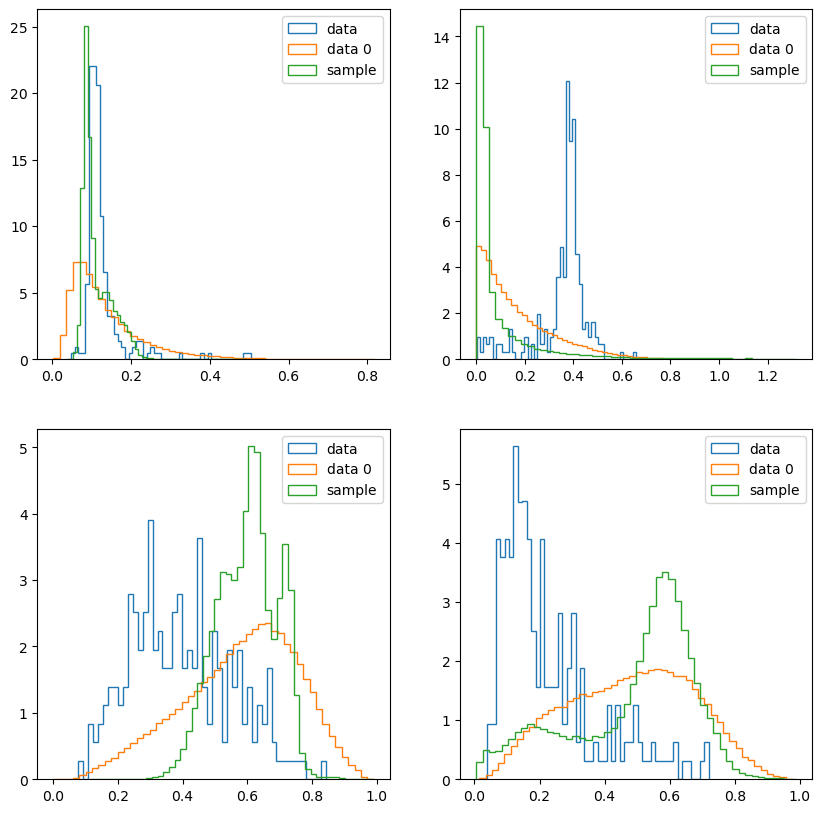

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  63 trainloss:  4.507713505904919 valloss:  2.951143114907401
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


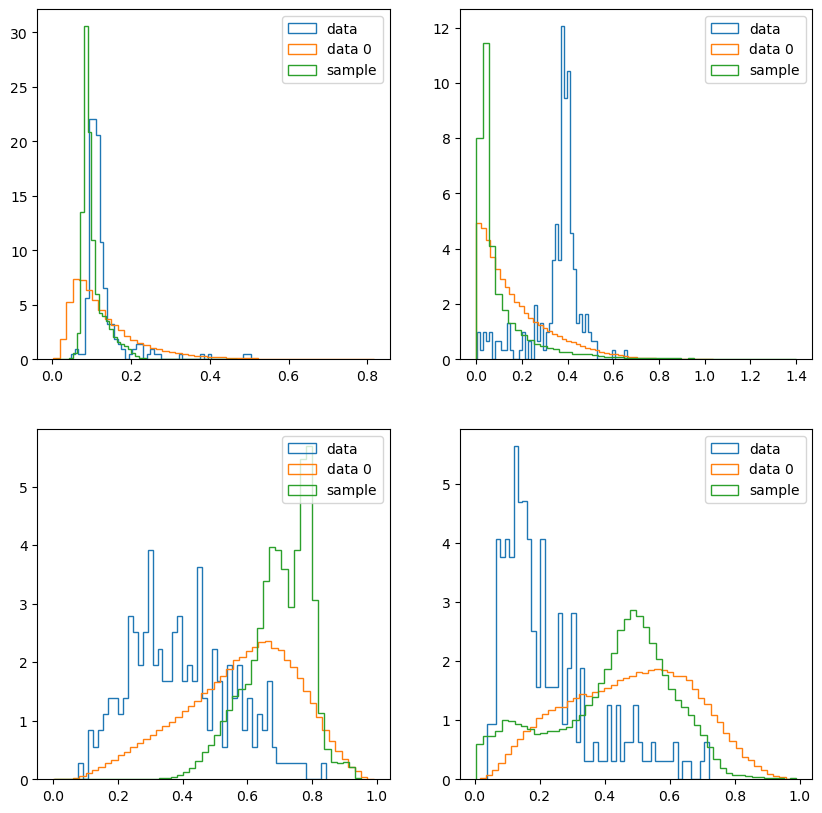

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  64 trainloss:  4.502417763853384 valloss:  2.9511414527893067
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


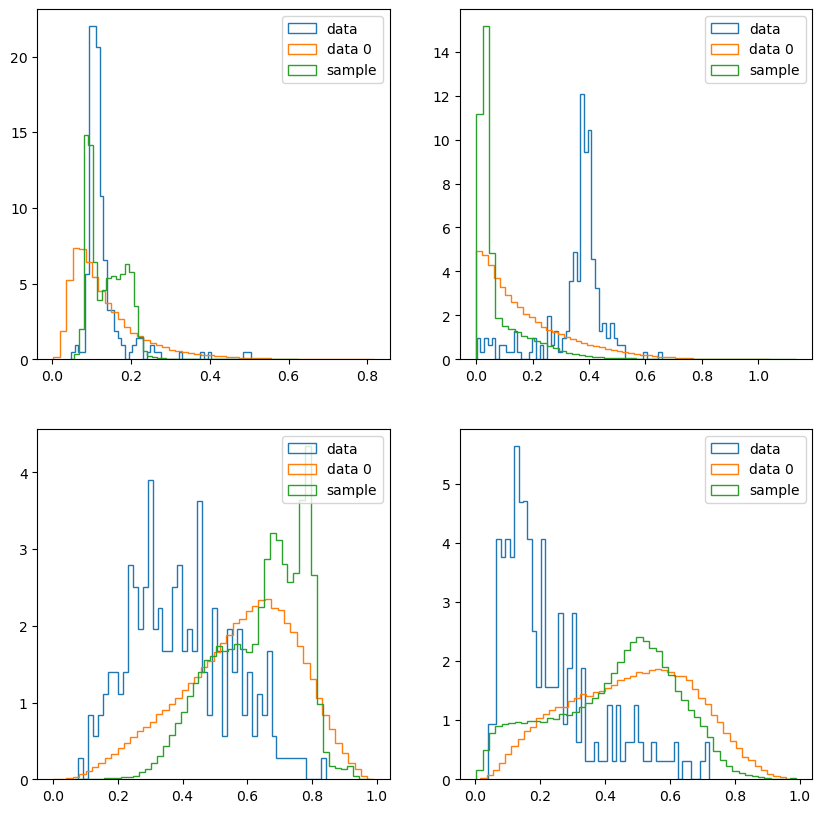

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  65 trainloss:  4.504969976047025 valloss:  2.951115526471819
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


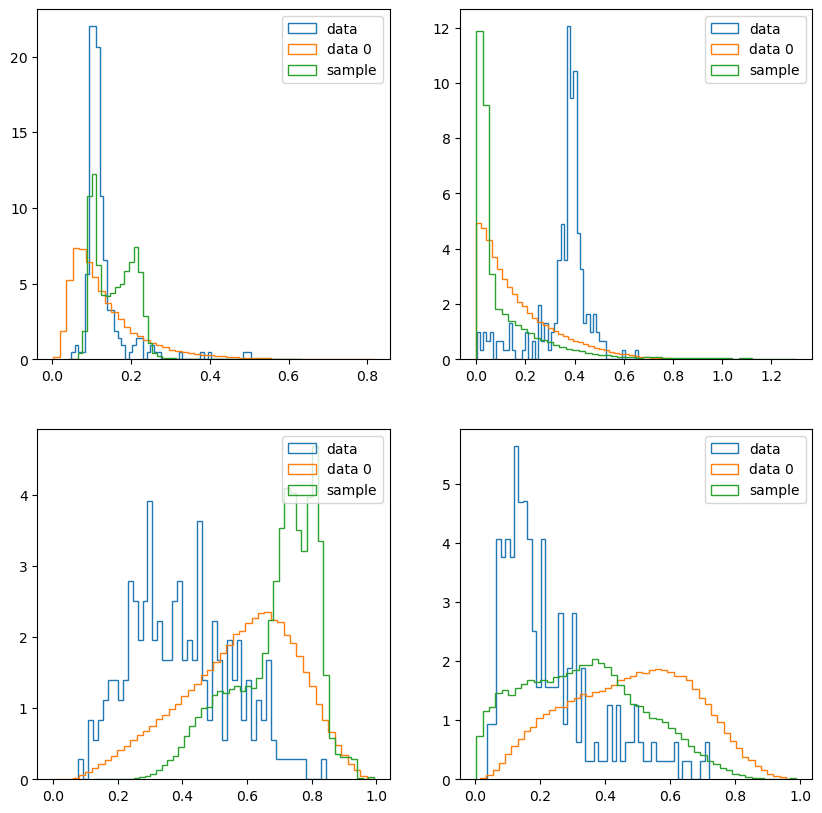

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  66 trainloss:  4.501342206738873 valloss:  2.9510870252336776
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


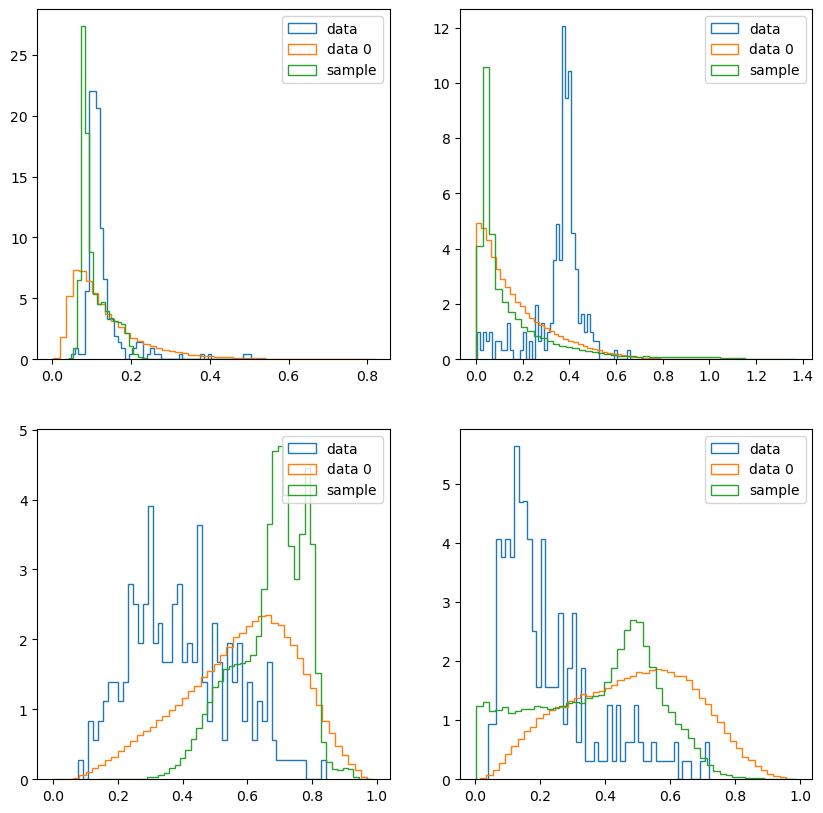

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  67 trainloss:  4.502598352162147 valloss:  2.9511261940002442
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


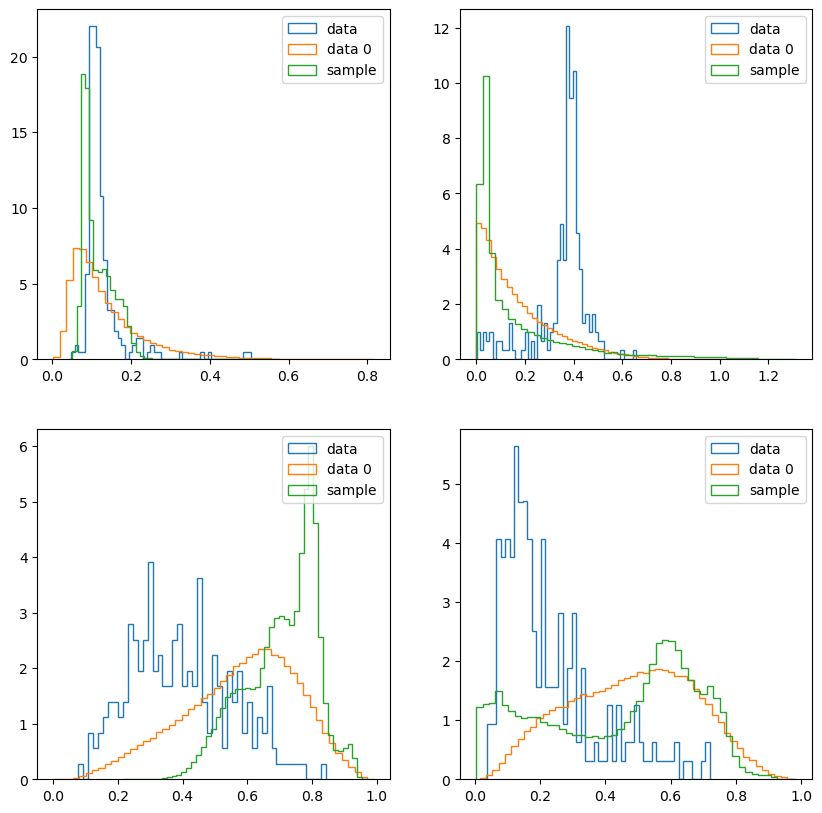

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  68 trainloss:  4.503831279563488 valloss:  2.9511612347194127
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


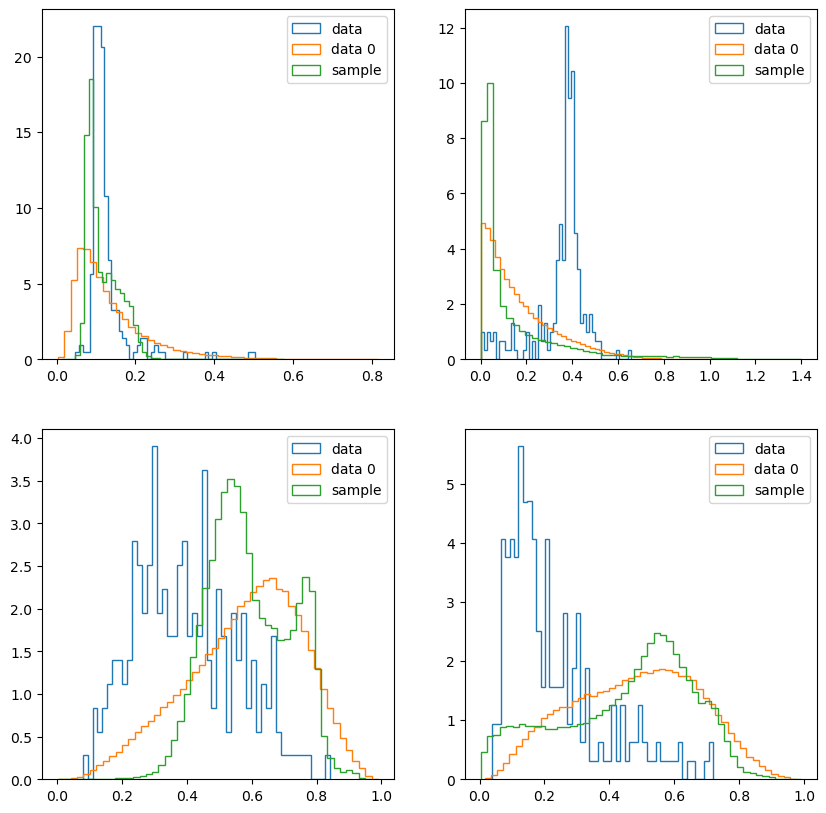

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  69 trainloss:  4.505592879127054 valloss:  2.9511586597987582
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


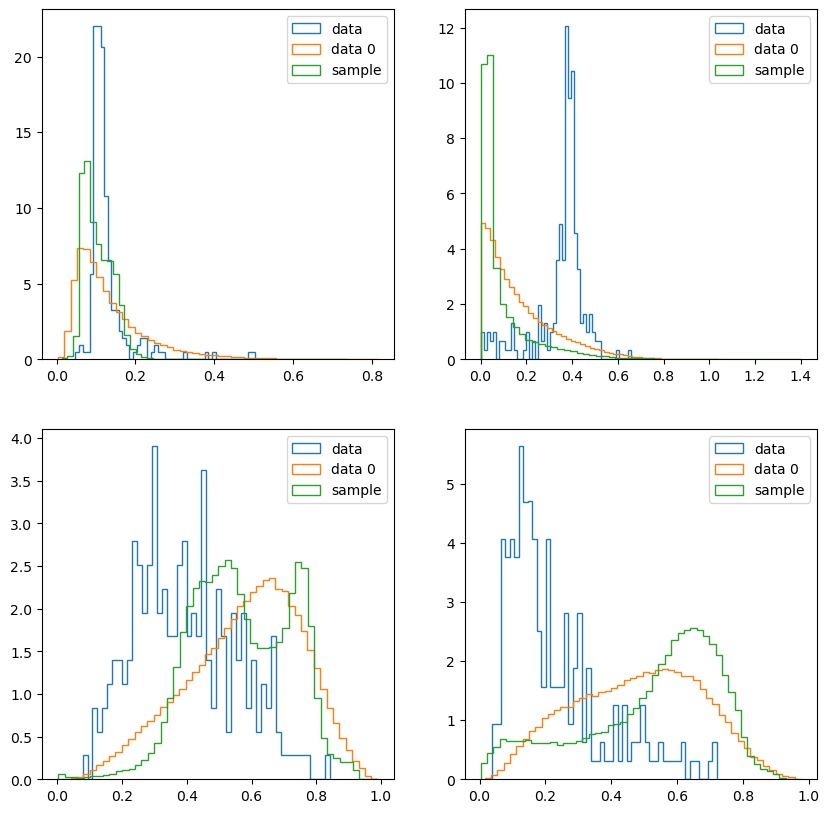

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  70 trainloss:  4.504533424876095 valloss:  2.9511319160461427
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


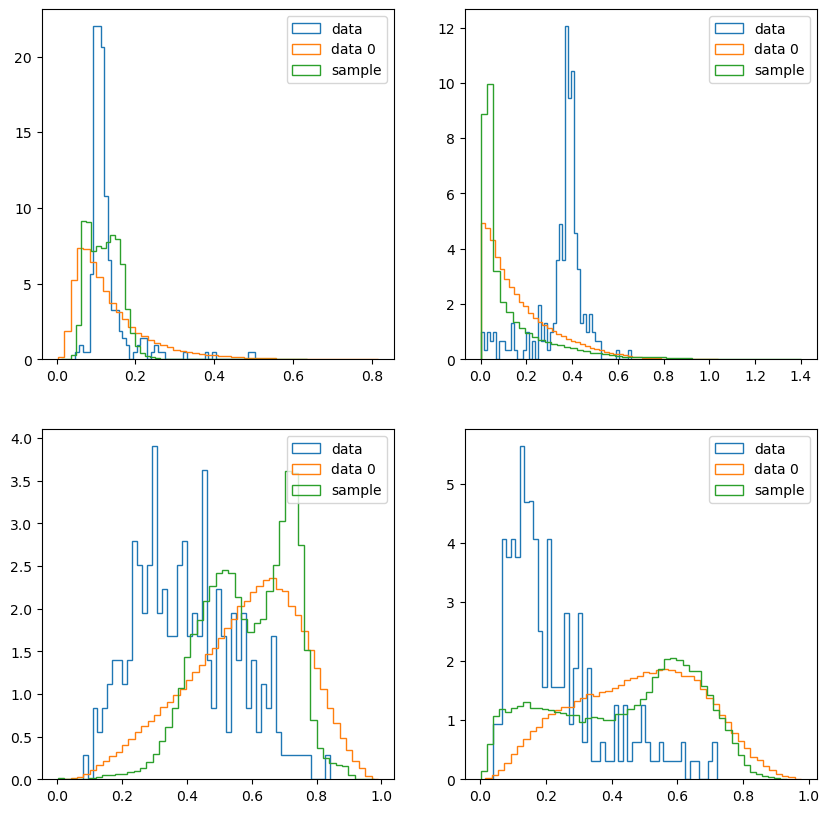

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  71 trainloss:  4.503036451235835 valloss:  2.9512063571384974
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


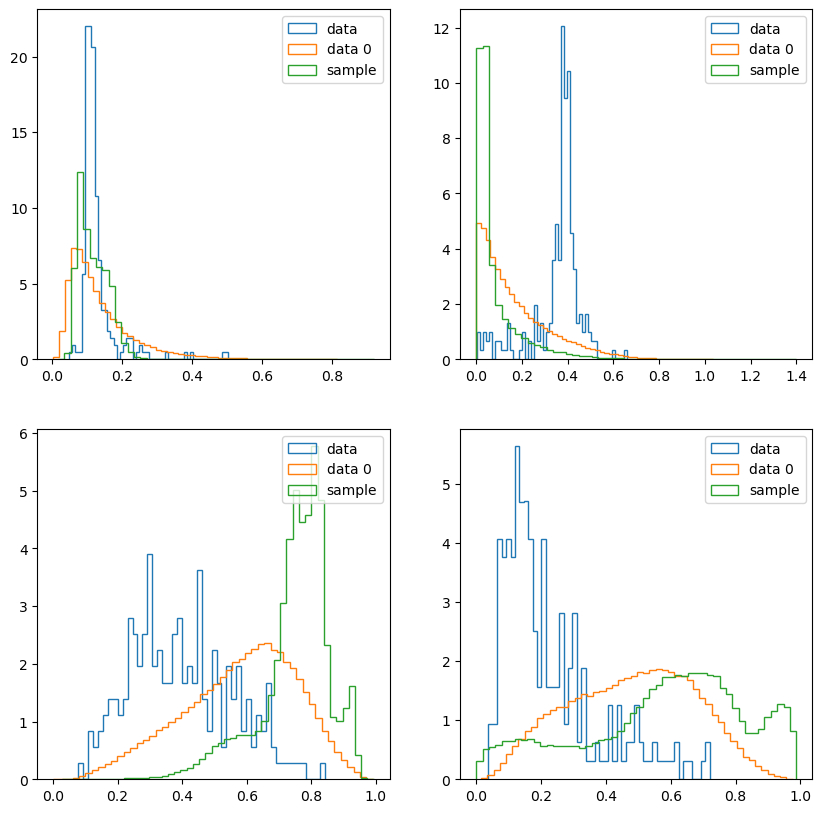

value of w: 0.0019245636833188032
value of w: 0.0019245636833188032
epoch:  72 trainloss:  4.502638726452597 valloss:  2.9512266159057616
x_samples shape torch.Size([97258, 5])
all_data shape (121573, 6)


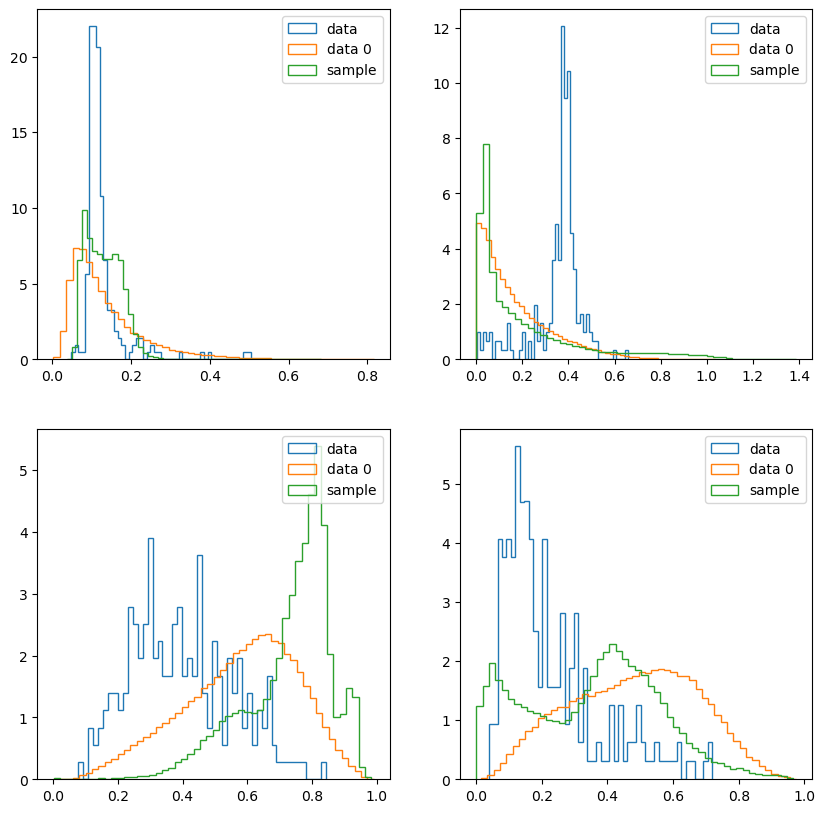

value of w: 0.0019245636833188032


In [31]:
lr = []
valloss = []
trainloss = []

for epoch in range(epochs):

    if epoch % 5 == 0:
        include_samples = False
    else:
        include_samples = False
   # include_samples = False

    train_loss = r_anode(model_S,model_B.model,true_w,optimizer, trainloader, 
                         pre_parameters, device=device, mode='train',\
                          data_loss_expr=args.data_loss_expr, include_samples=include_samples)
    val_loss = r_anode(model_S,model_B.model,true_w,optimizer, valloader, 
                       pre_parameters, device=device, mode='val',\
                        data_loss_expr=args.data_loss_expr, include_samples=include_samples)


    ##################################
    ##############################
    # Save model and weights

    torch.save(model_S.state_dict(), f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{epoch}.pt')

    
    if args.mode_background == 'train' or args.mode_background == 'pretrained':
        torch.save(model_B.model.state_dict(), f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_B_{epoch}.pt')


    if args.wandb:
            wandb.log({'train_loss': train_loss, 'val_loss': val_loss, \
                'true_w': true_w})


    if np.isnan(train_loss) or np.isnan(val_loss):
        print(' nan loss ')
       # if args.wandb:
        #    wandb.finish()
        #break

    

    print('epoch: ', epoch, 'trainloss: ', train_loss, 'valloss: ', val_loss)
    valloss.append(val_loss)
    trainloss.append(train_loss)
   # lr.append(scheduler.get_last_lr()[0])

    if ~(np.isnan(train_loss) or np.isnan(val_loss)):
        
  #  x_samples_train = generate_transformed_samples(model_S.model, traintensor_S, pre_parameters['SR'], device=device).cpu().detach().numpy()
  #  x_samples_val = generate_transformed_samples(model_S.model, valtensor_S, pre_parameters['SR'], device=device).cpu().detach().numpy()
       # x_samples_train = generate_transformed_samples(model_S, traintensor_S[0:100], pre_parameters['CR'], device=device).cpu().detach().numpy()
       # x_samples_val = generate_transformed_samples(model_S, valtensor_S[0:100], pre_parameters['CR'], device=device).cpu().detach().numpy()
      #  x_samples = model_S.sample(10000).detach().cpu()
      #  
        x_samples = model_S.sample(1, traintensor_S[:,0].reshape(-1,1)).detach().cpu()
        x_samples = x_samples.reshape(-1,4)
        x_samples = inverse_standardize(x_samples, pre_parameters_CR["mean"], pre_parameters_CR["std"])
        x_samples = inverse_logit_transform(x_samples, pre_parameters_CR["min"], pre_parameters_CR["max"])
        x_samples = torch.hstack((traintensor_S[:,0].reshape(-1,1).detach().cpu(), x_samples))
       # x_samples = np.vstack((x_samples_train, x_samples_val))
        x_samples = x_samples[~np.isnan(x_samples).any(axis=1)]
        

        print('x_samples shape', x_samples.shape)
        print('all_data shape', all_data.shape)

        figure = plt.figure(figsize=(10,10))
        for i in range(1,5):
            plt.subplot(2,2,i)
            #if dims > 1:
            plt.hist(all_data[:,i][all_data[:,-1]==1],bins=50, density=True, label=f'data', histtype='step')
            plt.hist(all_data[:,i][all_data[:,-1]==0],bins=50, density=True, label=f'data 0', histtype='step')
            plt.hist(x_samples[:,i],bins=50, density=True, label=f'sample', histtype='step')
            plt.legend(loc='upper right')
        # plt.title(f'Nflow vs S for {i}, epoch {epoch}')
            plt.savefig(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/nflow_S_{i}.png')
            if args.wandb:
                wandb.log({f'nflow_S': wandb.Image(figure)})

        plt.show()



In [ ]:
samples_train.shape

torch.Size([20000, 6])

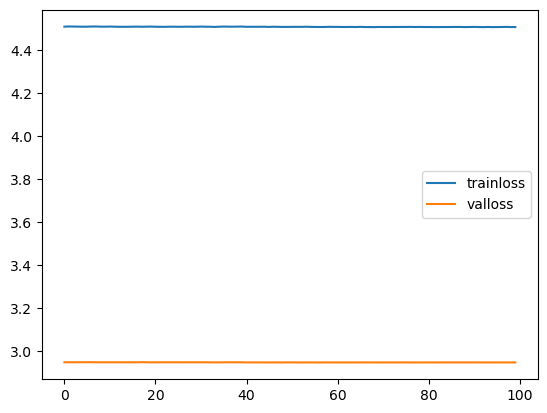

In [ ]:
plt.plot(trainloss, label='trainloss')
plt.plot(valloss, label='valloss')
plt.legend()
plt.show()

In [ ]:
np.argmin(valloss)

56

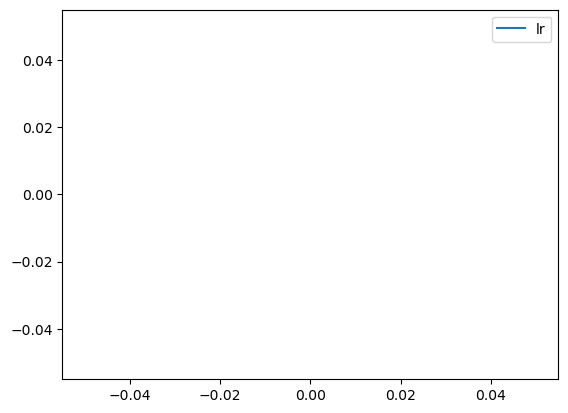

In [ ]:
plt.plot(lr, label='lr')
plt.legend()
plt.show()

In [ ]:
testloader = torch.utils.data.DataLoader(testtensor_S, batch_size=test_batch_size, shuffle=False)

DensityEstimator has 274800 parameters


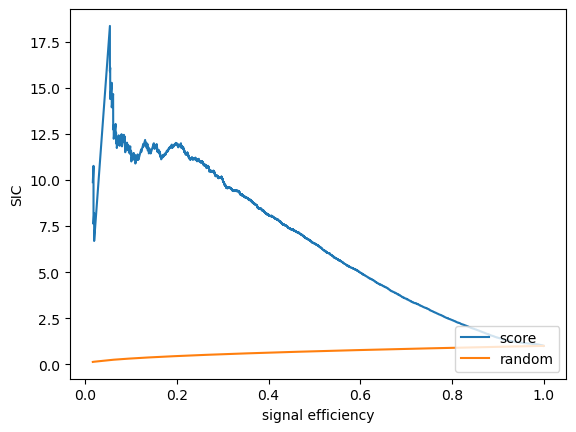

In [ ]:


#if ~np.isnan(train_loss) or ~np.isnan(val_loss):


# Load best model
if not args.ensemble:
    index = np.argmin(valloss).flatten()[0]

    model_S.model.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{index}.pt'))
    
    model_S.model.eval()
    log_S = evaluate_log_prob(model_S.model, testtensor_S, 
                                pre_parameters['SR'], transform = True).cpu().detach().numpy()
    #S = np.exp(log_S)


else:
    log_S = []
    sorted_index = np.argsort(valloss).flatten()[0:10]
    for index in sorted_index:

        model_S.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{index}.pt'))
        
        model_S.eval()
        log_S_ = []
        for i, data in enumerate(testloader):
                data = data.to(device)
                log_S_.extend(model_S.log_prob(data[:,1:-1],context=data[:,0].reshape(-1,1)).cpu().detach().numpy().tolist())
           
        #log_S_ = evaluate_log_prob(model_S.model, testtensor_S, 
                                    #pre_parameters['SR'], transform = True).cpu().detach().numpy()


        log_S.append(log_S_)

    log_S = np.array(log_S)
    S = np.exp(log_S)
    S = np.mean(S, axis=0)
    log_S = np.log(S + 1e-32)


if args.mode_background == 'train' or args.mode_background == 'pretrained':
    model_B.model.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_B_{index}.pt'))

test_data = inverse_transform(testtensor_S, pre_parameters['SR']).cpu().detach().numpy()
label_test = test_data[:,-1]

model_S.eval()

#train_data = inverse_transform(traintensor_S, pre_parameters['SR']).cpu().detach().numpy()
#val_data = inverse_transform(valtensor_S, pre_parameters['SR']).cpu().detach().numpy()



# load CR model
val_losses = np.load(f'{args.CR_path}/valloss_list.npy')

if not args.ensemble:
    best_epoch = np.argsort(val_losses)[0]
else:
    best_epoch = np.argsort(val_losses)[0:10]


model_B = DensityEstimator(args.config_file, eval_mode=True, device=device)
log_B = []
for epoch in best_epoch:
#  model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{epoch}.par", device=device)
    model_B.model.load_state_dict(torch.load(f'{args.CR_path}/model_CR_{epoch}.pt'))

    model_B.model.eval()
    with torch.no_grad():
        log_p = evaluate_log_prob(model_B.model, testtensor_B.to(device), pre_parameters['CR'], transform=False).cpu().detach().numpy()
        log_B.append(log_p)

log_B = np.array(log_B)
log_B = np.mean(log_B, axis=0)

likelihood_ = log_S - log_B
likelihood = np.nan_to_num(likelihood_, nan=0, posinf=0, neginf=0)        
mask = ~ (np.isnan(likelihood) | np.isinf(likelihood))

likelihood = likelihood[mask]
label_test_masked = label_test[mask]

sic_score , tpr_score , auc_score = SIC(label_test_masked, likelihood)

figure = plt.figure()

plt.plot(tpr_score, sic_score, label='score')
plt.plot(tpr_score, tpr_score**0.5, label='random')
plt.xlabel('signal efficiency')
plt.ylabel('SIC')

plt.legend(loc='lower right')
if args.wandb:
    wandb.log({'SIC': wandb.Image(figure)})
    wandb.log({'AUC': auc_score, 'max SIC': np.max(sic_score)})

plt.savefig(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/SIC.png')
plt.show()


# check density estimation


np.save(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/valloss.npy', valloss)
np.save(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/trainloss.npy', trainloss)

if args.wandb:
    wandb.finish()
